In [1]:
using DifferentialEquations, DataFrames
using Plots, CSV, XLSX, StatsPlots
using Optim, DiffEqParamEstim, Turing, Distributions
# First time takes a while

In [2]:
#Packages to import for the ESS
using Pkg
using DataStructures
using LatinHypercubeSampling
using LinearAlgebra
using Random
using Statistics
using Noise
using DataFrames


In [3]:
PATH_TO_MODELS = pwd()*"/models/"
PATH_TO_OUTPUT = pwd()*"/output/" # Path for output data, plots
FILENAME = "outputMM.csv" # Filename for output data
PLOTNAME = "plottraces.pdf"
MODELNAME = "TXTL_MM.jl"
include(PATH_TO_MODELS*MODELNAME);

## 1. Solve model

### Saturation kinetics model

\begin{align}
\dot{d} &= 0 \\
\dot{m} &= V_{maxTX} \alpha(t) \frac{d}{d+K_{TX}} - k_{deg}m \\
\dot{P} &= V_{maxTL} \alpha(t) \frac{m}{m+K_{TL}} - k_{mat}P \\
\dot{P_{mat}} &= k_{mat}P \\
\dot{\alpha} &= -\lambda \alpha \\
\end{align}

### Set up and solve ODEs

In [7]:
# Set up ODEs
u0 = valuesVar
PARAMS = valuesPar
tspan = 0,Float64(12*60) # time in min
prob = ODEProblem(model!,u0,tspan,PARAMS);

In [8]:
# Solve ODEs
# first time takes a while
sol_ODE = solve(prob,saveat=10);

### Output results

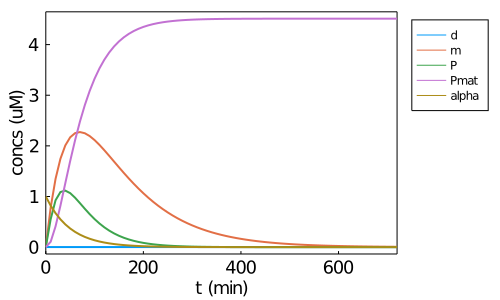

In [9]:
# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
p1 = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

# Plot data
plot!(sol_ODE, lw=2, labels=permutedims(keysVar),legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)")


In [ ]:
# Example script to save plot and data

# Save plot
savefig(PATH_TO_OUTPUT*PLOTNAME)

# Save data
CSV.write(PATH_TO_OUTPUT*FILENAME,sol_ODE)

## 2. Simulate model in microfluidic device

### Encode experimental protocol in callbacks

In [10]:
function marktime!(integrator)   
end

function condition(u,t,integrator) 
    t%INTERVAL_DIL # condition true when t is multiple of dilution interval
end

function dilute!(integrator)
    if integrator.t<SWITCHTIMES[1]
        # Stage 1
        INDEX_REFRESH = [idx_d,idx_A]
        CONC_REFRESH = [d0,A0]
        
        # first dilute everything
        for j in 1:NSPECIES
            integrator.u[j] = integrator.u[j]*(1-DIL_FRAC)
        end
        
        # then refresh appropriate species: here DNA and system activity A refreshed
        for j in 1:size(INDEX_REFRESH)[1]
            integrator.u[INDEX_REFRESH[j]] = integrator.u[INDEX_REFRESH[j]] + DIL_FRAC*CONC_REFRESH[j]
        end
        
    elseif SWITCHTIMES[1]<=integrator.t
        # Stage 2 - right now same as Stage 1
        INDEX_REFRESH = [idx_d,idx_A]
        CONC_REFRESH = [d0,A0]
        
        # first dilute everything
        for j in 1:NSPECIES
            integrator.u[j] = integrator.u[j]*(1-DIL_FRAC)
        end
        
        # then refresh appropriate species: here DNA and system activity A refreshed
        for j in 1:size(INDEX_REFRESH)[1]
            integrator.u[INDEX_REFRESH[j]] = integrator.u[INDEX_REFRESH[j]] + DIL_FRAC*CONC_REFRESH[j]
        end
        
    end
end

function dilute_vec!(integrator)
    if integrator.t<(TMAX/length(SWITCHTIMES))*SWITCH
        # Stage 1
        INDEX_REFRESH = [idx_d,idx_A]
        CONC_REFRESH = [d0,A0]
        
        # first dilute everything
        for j in 1:NSPECIES
            integrator.u[j] = integrator.u[j]*(1-SWITCHTIMES[SWITCH])
        end
        
        # then refresh appropriate species: here DNA and system activity A refreshed
        for j in 1:size(INDEX_REFRESH)[1]
            integrator.u[INDEX_REFRESH[j]] = integrator.u[INDEX_REFRESH[j]] + SWITCHTIMES[SWITCH]*CONC_REFRESH[j]
        end
        
    elseif (TMAX/length(SWITCHTIMES))*SWITCH <integrator.t

        global SWITCH += 1

        # Stage 2 - right now same as Stage 1
        INDEX_REFRESH = [idx_d,idx_A]
        CONC_REFRESH = [d0,A0]
        
        # first dilute everything
        for j in 1:NSPECIES
            integrator.u[j] = integrator.u[j]*(1-SWITCHTIMES[SWITCH])
        end
        
        # then refresh appropriate species: here DNA and system activity A refreshed
        for j in 1:size(INDEX_REFRESH)[1]
            integrator.u[INDEX_REFRESH[j]] = integrator.u[INDEX_REFRESH[j]] + SWITCHTIMES[SWITCH]*CONC_REFRESH[j]
        end
        
    end
end

function solvemodel(grads,u0,PARAMS,TMAX,INTERVAL_DIL,tsave,DIL_FRAC,NSPECIES,SWITCHTIMES)
    tspan = (0.0,TMAX); 
    prob = ODEProblem(grads,u0,tspan,PARAMS);

    # Callbacks

    contcb = ContinuousCallback(condition,dilute!;save_positions=(false,false))
    periodcb = PeriodicCallback(marktime!,INTERVAL_DIL;save_positions=(false,false)) # hack to mark time points for dilution
    cb = CallbackSet(periodcb,contcb)

    # Solve
    sol = solve(prob, callback=cb,saveat=tsave);
    return(sol) # Return trajectories
end

function solvemodel_frac(grads,u0,PARAMS,TMAX,INTERVAL_DIL_VEC,tsave,DIL_FRAC,NSPECIES,SWITCHTIMES)
    tspan = (0.0,TMAX); 
    prob = ODEProblem(grads,u0,tspan,PARAMS);
    global SWITCH = 1

    # Callbacks

    contcb = ContinuousCallback(condition,dilute_vec!;save_positions=(false,false))
    periodcb = PeriodicCallback(marktime!,INTERVAL_DIL;save_positions=(false,false)) # hack to mark time points for dilution
    cb = CallbackSet(periodcb,contcb)

    # Solve
    sol = solve(prob, callback=cb,saveat=tsave);
    global SWITCH = 1;
    return(sol) # Return trajectories
end

solvemodel_frac (generic function with 1 method)

### Simulate

In [11]:
# Global simulation settings
TMAX = 12.0*60 # in minutes
INTERVAL_DIL = 40.0 # in minutes
DIL_FRAC = 0.9;
NSPECIES = 5
SWITCHTIMES = [120] # Time to swap between experimental stages, in minutes

# 1. Define names for species indices
idx_d=1;
idx_m=2;
idx_P=3;
idx_Pmat=4;
idx_A=5;

# 2. Set initial conditions and parameters
d0=1.00;
m0=0.0;
P0=0.0;
Pmat0=0.0;
A0=1.0;

Vmaxtx=1.0;
KTX=0.01;
kdeg=0.01;
Vmaxtl=0.1;
KTL=0.1;
kmat=0.03;
lamb=0.02;

u0 = [d0,m0,P0,Pmat0,A0];
PARAMS = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb];

In [12]:
# 3. Solve

# Save data frequently e.g. every 2 minutes to observe sawtooth behaviour:
TSAVE = collect(0:2:TMAX) 

# Or save at each dilution step to see smooth trace (similar to experiment):
#TSAVE = collect(0:INTERVAL_DIL:TMAX) 
@time begin
solU,solDU=solvemodel(model!,u0,PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES);
end
t = solU.t;
d = [datum for subarr in solU.u for datum in subarr[idx_d]];
m = [datum for subarr in solU.u for datum in subarr[idx_m]];
P = [datum for subarr in solU.u for datum in subarr[idx_P]];
Pmat = [datum for subarr in solU.u for datum in subarr[idx_Pmat]];
A = [datum for subarr in solU.u for datum in subarr[idx_A]];

  8.243602 seconds (14.33 M allocations: 706.396 MiB, 3.60% gc time)


In [13]:
global SWITCH = 1
SWITCHTIMES = [0.6,0.3,0.6,0.9]
@time begin
solU,solDU=solvemodel_frac(model!,u0,PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES);
end
t = solU.t;
d = [datum for subarr in solU.u for datum in subarr[idx_d]];
m = [datum for subarr in solU.u for datum in subarr[idx_m]];
P = [datum for subarr in solU.u for datum in subarr[idx_P]];
Pmat = [datum for subarr in solU.u for datum in subarr[idx_Pmat]];
A = [datum for subarr in solU.u for datum in subarr[idx_A]];

# Plot options
PLOTNAME = "AAA fig1Abis.svg"
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
p2 = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

# Plot data
plot!(t,d, lw=2, labels="d",legend = :outertopright) 
plot!(t,m, lw=2, labels="m") 
plot!(t,P, lw=2, labels="P") 
plot!(t,Pmat, lw=2, labels="Pmat") 
plot!(t,A, lw=2, labels="A") 
plot!(xaxis = "t (min)",yaxis="concs (uM)")
savefig(PATH_TO_OUTPUT*PLOTNAME)

  5.698054 seconds (7.48 M allocations: 391.383 MiB, 2.39% gc time)


In [52]:
##Stock variable
#Control 1
SWITCHTIMES = [0.3, 0.9, 0.3, 0.9, 0.3, 0.9]
#Contrl1 = [Ctrl1_Ecrit, Ctrl1_Dcrit, Ctrl1_totalerror, Ctrl1_varerror]
#Ctrl1INPOP_Dcrit = BestINPOP_E 
#Ctrl1INPOP_Ecrit = BestINPOP_E 

#Control 2
#SWITCHTIMES = [0.3, 0.6, 0.9, 0.6, 0.3, 0.0]
#Contrl2 = [Ctrl2_Ecrit, Ctrl2_Dcrit, Ctrl2_totalerror, Ctrl2_varerror]
#Ctrl2INPOP_Dcrit = BestINPOP_D 
#Ctrl12NPOP_Ecrit = BestINPOP_E 

#Control 3
SWITCHTIMES = [0.9, 0.9, 0.3, 0.0, 0.6, 0.0]
#Contrl3 = [Ctrl3_Ecrit, Ctrl3_Dcrit, Ctrl3_totalerror, Ctrl3_varerror]
#Ctrl3INPOP_Dcrit = BestINPOP_D 
#Ctrl3NPOP_Ecrit = BestINPOP_E 

#Selective tree
SWITCHTIMES= [0.3, 0.6, 0.3, 0.3, 0.0, 0.6]
SelTree = [Sel_Ecrit, Sel_Dcrit, Sel_totalerror, Sel_varerror]
#Random design
#Rd_ED =[Rd_Ecrit, Rd_Dcrit, Rd_totalerror, Rd_varerror]
#Rd_Ecrit = BestINPOP_E
#Rd_Dcrit = BestINPOP_D 


#Rd2_ED =[Rd2_Ecrit, Rd2_Dcrit, Rd2_totalerror, Rd2_varerror,Rd2_memory]

#BestRD_Mat = [BstRD_Ecrit,BstRD_Dcrit, BstRD_totalerror, BstRD_varerror]
#BestRd_Ecrit = BestINPOP_E
#BestRDcrit = BestINPOP_D


Dict{Any,Any} with 25 entries:
  18 => [2.897; 0.121437; … ; 0.0199504; 0.0331853]
  2  => [6.87628; 0.0001; … ; 0.0176343; 0.0340063]
  16 => [5.4451; 0.0222075; … ; 0.0291178; 0.0204203]
  11 => [5.38906; 0.0349529; … ; 0.0294326; 0.0204795]
  21 => [19.9751; 0.0015438; … ; 0.0117133; 0.0460789]
  7  => [24.2091; 0.00138775; … ; 0.0114312; 0.0476101]
  9  => [6.77456; 0.0284722; … ; 0.0175583; 0.0339829]
  25 => [34.6103; 0.0384463; … ; 0.0117558; 0.0483656]
  10 => [25.4072; 0.00924175; … ; 0.0115012; 0.0472724]
  19 => [39.9545; 0.0729287; … ; 0.00927817; 0.0557393]
  17 => [22.7846; 0.00234722; … ; 0.0114518; 0.0480652]
  8  => [24.8279; 0.0168287; … ; 0.0113911; 0.0473287]
  22 => [27.2431; 0.000388647; … ; 0.0113238; 0.0475452]
  6  => [23.6212; 0.0170137; … ; 0.01139; 0.0479757]
  24 => [5.79041; 0.0836509; … ; 0.0396201; 0.0145552]
  4  => [6.68114; 0.077229; … ; 0.0175968; 0.0338074]
  3  => [23.4247; 0.00937123; … ; 0.0115103; 0.0470544]
  5  => [5.39858; 0.0001; … ; 0.02985

In [33]:
Rd_ED


4-element Array{Array{Any,1},1}:
 [4.104382501681913e-9, 8.22488833622063e-12, 5.158879360076456e-11, 1.1199125313424993e-9, 1.9212577512767732e-8, 4.632118035424216e-8, 5.1019513983700294e-8, 2.839035153672792e-7, 1.1828304272563671e-7, 1.5362055229043038e-9  …  3.897533763445153e-9, 1.638445973020289e-10, 6.661636923708623e-10, 1.0124066321795113e-7, 7.34851897118628e-7, 3.020841992182916e-8, 1.4736631459705952e-7, 1.4053195026222588e-9, 7.942929058245832e-10, 4.147763633388156e-9]
 [4.32862630808995e-27, 9.683751687232904e-22, 7.482574615920999e-26, 4.875936024955067e-30, 2.7358975394353404e-29, 1.2521197646160165e-20, 3.706436811770732e-22, 3.744725098072418e-22, 8.488552874288718e-20, 1.2185575857988972e-26  …  9.604479708117989e-20, 9.730599756926203e-30, 4.452516557893712e-31, 8.68868148635064e-22, 2.208026757177495e-19, 1.2771407403260403e-22, 4.98955554416113e-19, 6.701022105417108e-26, 1.5431348094499723e-22, 2.6513279931157964e-25]
 [3.71622951116748, 8.746674029566503, 5.18

In [119]:
BestRandom = Rd2_ED[5]
BestRD = BestRandom[36:42]

7-element Array{Any,1}:
 0.3
 0.0
 0.3
 0.3
 0.9
 0.3
 0.0

In [43]:
BestRD= [0.3, 0.0, 0.3, 0.3, 0.9, 0.3, 0.0]

7-element Array{Float64,1}:
 0.3
 0.0
 0.3
 0.3
 0.9
 0.3
 0.0

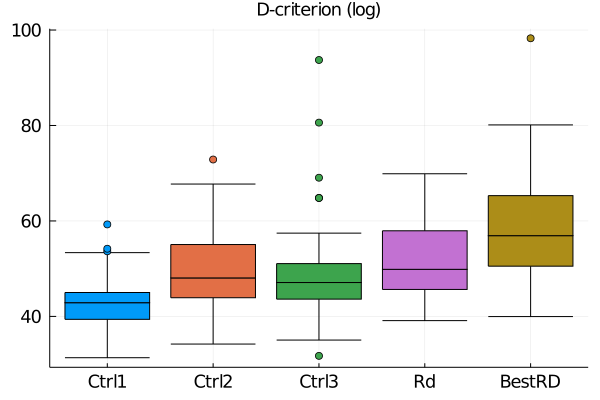

In [55]:

PLOTNAME = "AAA Fig 5 DCrit.svg"
Dcrit_RelER= [map(x -> log(1/x),Contrl1[2]),map(x -> log(1/x),Contrl2[2]),map(x -> log(1/x),Contrl3[2]),map(x -> log(1/x),Rd_ED[2]),map(x -> log(1/x),BestRD_Mat[2])]
boxplot(Dcrit_RelER,xticks=(1:5,["Ctrl1" "Ctrl2" "Ctrl3" "Rd" "BestRD"]),label = false, title="D-criterion (log)")
#savefig(PATH_TO_OUTPUT*PLOTNAME)

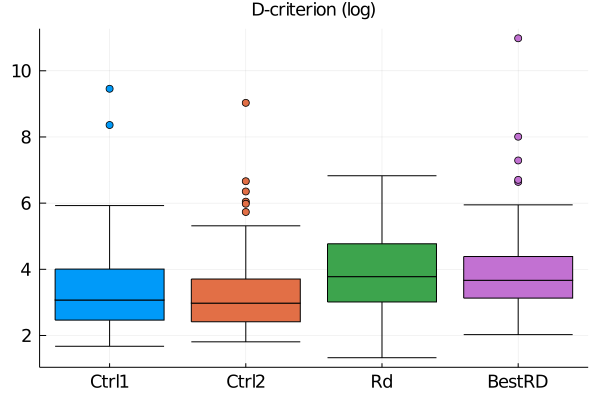

In [50]:
Dcrit_RelER= [map(x -> log(x),Contrl1[4]),map(x -> log(x),Contrl2[4]), map(x -> log(x),Rd_ED[4]),map(x -> log(x),BestRD_Mat[4])]
boxplot(Dcrit_RelER,xticks=(1:5,["Ctrl1" "Ctrl2" "Rd" "BestRD"]),label = false, title="D-criterion (log)")

In [214]:
PLOTNAME = "AAA Fig 5 ECrit.svg"
Ecrit_RelER= [map(x -> log(x),Contrl1[1]),map(x -> log(x),Contrl2[1]),map(x -> log(x),Contrl3[1]),map(x -> log(x),Positive(Rd2_ED[1])),map(x -> log(x),BestRD_Mat[1])]
boxplot(Ecrit_RelER,xticks=(1:5,["Ctrl1" "Ctrl2" "Ctrl3" "Rd" "BestRD"]),label = false, title="E-criterion (log)")
savefig(PATH_TO_OUTPUT*PLOTNAME)


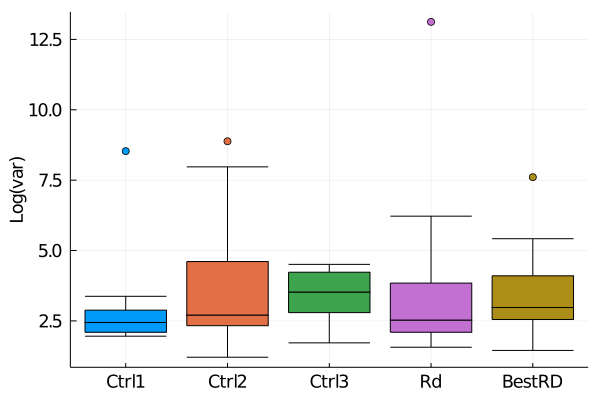

In [251]:
PLOTNAME = "AAA Fig3 Var.svg"
Var_RelER= [map(x -> log(x),Contrl1[4]),map(x -> log(x),Contrl2[4]),map(x -> log(x),Contrl3[4]),map(x -> log(x),Positive(Rd2_ED[4])),map(x -> log(x),BestRD_Mat[4])]
boxplot(Var_RelER,xticks=(1:5,["Ctrl1" "Ctrl2" "Ctrl3" "Rd" "BestRD"]),label = false, ylabel="Log(var)")
#savefig(PATH_TO_OUTPUT*PLOTNAME)

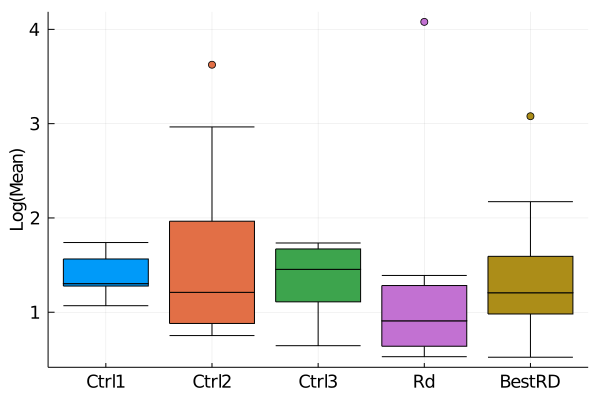

In [238]:
PLOTNAME = "AAA Fig3 Mean.svg"
Var_RelER= [map(x -> log(x),Contrl1[3]),map(x -> log(x),Contrl2[3]),map(x -> log(x),Contrl3[3]),map(x -> log(x),Positive(Rd2_ED[3])),map(x -> log(x),BestRD_Mat[3])]
boxplot(Var_RelER,xticks=(1:5,["Ctrl1" "Ctrl2" "Ctrl3" "Rd" "BestRD"]),label = false, ylabel="Log(Mean)")
#savefig(PATH_TO_OUTPUT*PLOTNAME)

In [51]:
NPARAM = 7
POPSIZE = 25
NBGEN = 100
INTERVAL_DIL = 10
TMAX=400.
TSAVE = collect(0:2:TMAX)
PARA_ref = copy(PARAMS)
PARA_var = ones(7,1)
#PARA_var= [0,1,0,0,1,0,0]
#SWITCHTIMES = [0.8, 0.8, 0.8,0.4,0.8]
#SWITCHTIMES = [0.3, 0.9, 0.9, 0.3, 0.6]
#SWITCHTIMES = [0.6, 0.3, 0.3, 0.6, 0.3]
#Round 2
#SWITCHTIMES = [0.3, 0.1, 0.6, 0.7, 0.4]

SWITCHTIMES = 0.1
DIL_FRAC = 0.9


#Control 2
#SWITCHTIMES = [0.3, 0.6, 0.9, 0.6, 0.3, 0.0]
#Ctrl2_Ecrit =[]
#Ctrl2_Dcrit =[]
#Ctrl2_totalerror =[]
#Ctrl2_varerror =[]

#Control 1
#SWITCHTIMES = [0.3, 0.9, 0.3, 0.9, 0.3, 0.9]
#Ctrl1_Ecrit =[]
#Ctrl1_Dcrit =[]
#Ctrl1_totalerror =[]
#Ctrl1_varerror =[]


#Control 3
#SWITCHTIMES = [0.3, 0.6, 0.9, 0.6, 0.3, 0.0]
#Ctrl3_Ecrit =[]
#Ctrl3_Dcrit =[]
#Ctrl3_totalerror =[]
#Ctrl3_varerror =[]

#Random 
#Rd_Ecrit =[]
#Rd_Dcrit =[]
#Rd_totalerror =[]
#Rd_varerror =[]
#Rd_memory = []

#BestRD
#BstRD_Ecrit =[]
#BstRD_Dcrit =[]
#BstRD_totalerror =[]
#BstRD_varerror =[]

#Selective tree
SWITCHTIMES= [0.3, 0.6, 0.3, 0.3, 0.0, 0.6]
Sel_Ecrit =[]
Sel_Dcrit =[]
Sel_totalerror =[]
Sel_varerror =[]

BestINPOP_E = Dict()
BestINPOP_D = Dict()
BestECRIT = 1
BestDCRIT = 1
for t in 1:50
    DESIGN_SPACE = [0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.3,0.3,0.3,0.3,0.3,0.6,0.6,0.6,0.6,0.6,0.6,0.9,0.9,0.9,0.9,0.9,0.9]
    #DESIGN = shuffle!(DESIGN_SPACE)
    #DESIGN = DESIGN[1:6]
    #SWITCHTIMES=DESIGN
    #SWITCHTIMES = BestRD
    naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    naive_ref = add_gauss(naive_ref, 0.05)
    naive_ref = Positive(naive_ref)
    online = 1
    IniPara = [(1,1)]
    INPOP = ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)
    ecrit = Score_OED_Ecrit(INPOP)
    dcrit = Score_OED_Dcrit(INPOP)
    append!(Sel_Dcrit, dcrit)
    append!(Sel_Ecrit, ecrit)

    EST_PARA = zeros(Float64, POPSIZE, 7)
    j = 1
    for i in values(INPOP)
        EST_PARA[j, :] = i
        j += 1
    end

    if ecrit <= BestECRIT
        BestINPOP_E = INPOP
    end
    if dcrit <= BestDCRIT
        BestINPOP_D = INPOP
    end


    REL_ER = RelativeError(PARAMS, EST_PARA)
    meanEr = mean(REL_ER)
    varEr = var(REL_ER)
    append!(Sel_totalerror, meanEr)
    append!(Sel_varerror, varEr)
    #append!(Rd_memory,DESIGN)
end

, (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation 1
Best score:1.7113911850194783 Worst score:12.345026530465676
Generation 2
Best score:0.970005178284855 Worst score:11.613837567926966
Generation 3
Best score:0.8324871827679516 Worst score:11.215036077168731
Generation 4
Best score:0.7413936282951877 Worst score:9.231738007365687
Generation 5
Best score:0.7123267711595934 Worst score:6.395641534897999
Generation 6
Best score:0.7116850295069972 Worst score:3.6970506340918274
Generation 7
Best score:0.7116850295069972 Worst score:2.2680640600162407
Generation 8
Best score:0.7108091311848441 Worst score:1.4465666241234951
Generation 9
Best score:0.7107097053252934 Worst score:1.0666594326286905
Generation 10
Best score:0.7101977109014023 Worst score:0.8089576390091986
Generation 11
Best score:0.7101977109014023 Worst score:0.78447287055298
Generation 12
Best score:0.7101977109014023 Worst score:0.781560131941737
Generation 13
Best score:0.7101977109014023 Worst score:0.7

In [283]:
DIL_FRAC = 0.1
INTERVAL_DIL = 100
SWITCHTIMES =[0.1]
#SWITCHTIMES =  [0.9, 0.9, 0.3, 0.0, 0.6, 0.0]
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
naive_ref = add_gauss(naive_ref, 0.05)
naive_ref = Positive(naive_ref)
INPOP = ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)

[(0.1, 10.0), (0.001, 0.1), (0.001, 0.1), (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation 1
Best score:4.791046728469674 Worst score:19.593024689504908
Generation 2
Best score:0.731928976499278 Worst score:18.966139177854693
Generation 3
Best score:0.6836609874554023 Worst score:18.545833301014653
Generation 4
Best score:0.6836609874554023 Worst score:16.38060671720615
Generation 5
Best score:0.6836609874554023 Worst score:11.310771632123894
Generation 6
Best score:0.6836609874554023 Worst score:9.745488624659375
Generation 7
Best score:0.6538124162481237 Worst score:7.935913555130466
Generation 8
Best score:0.639696028781862 Worst score:4.9458970061541665
Generation 9
Best score:0.639696028781862 Worst score:4.454210467873528
Generation 10
Best score:0.6286444178539667 Worst score:3.2906521475991926
Generation 11
Best score:0.6280756913421671 Worst score:2.8921957283258783
Generation 12
Best score:0.6280756913421671 Worst score:2.8921957283258783
Generation 13
Best sc

Dict{Any,Any} with 25 entries:
  18 => [26.1728; 0.0248419; … ; 0.0139687; 0.0974467]
  2  => [63.6912; 0.0207952; … ; 0.0140687; 0.0968916]
  16 => [28.1959; 0.0197807; … ; 0.0140894; 0.0996611]
  11 => [27.0292; 0.0195217; … ; 0.0141559; 0.0995065]
  21 => [27.7077; 0.0199138; … ; 0.0140694; 0.0965976]
  7  => [61.2031; 0.0242128; … ; 0.0140845; 0.0966638]
  9  => [55.9705; 0.0219245; … ; 0.0140319; 0.0982129]
  25 => [33.3817; 0.0158521; … ; 0.0139717; 0.0996365]
  10 => [31.6149; 0.0171964; … ; 0.0140848; 0.0992536]
  19 => [61.0615; 0.022385; … ; 0.0142067; 0.096887]
  17 => [27.8907; 0.0196522; … ; 0.0141485; 0.100034]
  8  => [28.3776; 0.0173706; … ; 0.0139967; 0.100342]
  22 => [47.1716; 0.0210117; … ; 0.0142527; 0.0987183]
  6  => [27.0503; 0.0204079; … ; 0.0139492; 0.100578]
  24 => [17.6134; 0.0295835; … ; 0.0139964; 0.0962429]
  4  => [26.4839; 0.0143973; … ; 0.0139544; 0.098048]
  3  => [60.1248; 0.0205912; … ; 0.0140374; 0.0975613]
  5  => [51.0855; 0.0220622; … ; 0.01407

In [254]:
INPOP= Rd_Ecrit

Dict{Any,Any} with 25 entries:
  18 => [800.808; 3.22207e-5; … ; 0.0270731; 0.0213797]
  2  => [775.326; 0.0001; … ; 0.0288797; 0.0201354]
  16 => [3398.82; 0.00226237; … ; 0.0281683; 0.0206308]
  11 => [2108.07; 0.00419689; … ; 0.028464; 0.0204116]
  21 => [621.547; 0.00230017; … ; 0.027069; 0.0214032]
  7  => [1133.03; 0.00618581; … ; 0.0287847; 0.0201823]
  9  => [642.194; 0.0001; … ; 0.0288995; 0.0201521]
  25 => [113.891; 0.000119084; … ; 0.0245702; 0.0235405]
  10 => [2086.78; 0.00410289; … ; 0.0285161; 0.0203768]
  19 => [637.031; 0.00485329; … ; 0.0270696; 0.0213924]
  17 => [987.512; 0.0001; … ; 0.029061; 0.0201422]
  8  => [3167.02; 0.00386776; … ; 0.0289041; 0.0200754]
  22 => [610.781; 0.00251651; … ; 0.0270667; 0.0214028]
  6  => [743.452; 0.00619055; … ; 0.02879; 0.0201897]
  24 => [1164.68; 0.00273324; … ; 0.0270738; 0.0214209]
  4  => [3139.88; 0.00533888; … ; 0.0289626; 0.0200744]
  3  => [636.018; 0.0001; … ; 0.0288801; 0.0201386]
  5  => [1904.66; 0.00597866; … ; 0.0

In [236]:
INPOP[1]

7×1 Array{Float64,2}:
 108.29701409497517
   0.02294695104797894
   0.053062101635494775
   0.09528135123020554
   0.0001
   0.027072786026908557
   0.0193903431959099

In [286]:
EST_PARA = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    EST_PARA[j, :] = i
    j += 1
end
REL_ER = RelativeError(PARAMS, EST_PARA)

PLOTNAME = "AAA Fig2 t100 d01.svg"
violin( xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]),label = false, REL_ER, ylabel = "Relative error", title = "Parameter estimation" )
savefig(PATH_TO_OUTPUT*PLOTNAME)

In [74]:
var(REL_ER)

500038.87586781086

In [72]:
PLOTNAME = "AAA  Round 2"
violin( xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]),label = false, REL_ER, ylabel = "Relative error", title = "Parameter estimation" )
savefig(PATH_TO_OUTPUT*PLOTNAME)

In [73]:
Para_after_first_round = Get_final_State(EST_PARA)
IniPara = Para_after_first_round
online = 1
PARA_var= [0,1,0,0,1,0,0]
Round1 = OED_V0(5)


ore:0.032101589932342786
Generation 16
Best score:0.00028559602002388483 Worst score:0.032101589932342786
Generation 17
Best score:0.00028559602002388483 Worst score:0.032101589932342786
Generation 18
Best score:0.00027669004499568796 Worst score:0.032101589932342786
[(1.0, 1.0), (0.001, 0.1), (0.01, 0.01), (0.1, 0.1), (0.01, 1.0), (0.03, 0.03), (0.02, 0.02)]
Generation 1
Best score:0.09592113902461016 Worst score:13.850302417283652
Generation 2
Best score:0.03450297278108051 Worst score:13.774165218549658
Generation 3
Best score:0.0052965251365560745 Worst score:12.922012076279515
Generation 4
Best score:0.0052965251365560745 Worst score:7.35113450593949
Generation 5
Best score:0.0008957013728962135 Worst score:0.6118050003516234
Generation 6
Best score:0.0007238657147476654 Worst score:0.1842708527342413
Generation 7
Best score:0.00022510668757681526 Worst score:0.09015744579801828
Generation 8
Best score:0.00022510668757681526 Worst score:0.07637349741024725
Generation 9
Best score:

(0.0, [0.5, 0.1, 0.2, 0.7, 0.3])

In [62]:
Para_after_first_round = Get_final_State(REL_ER)

7-element Array{Tuple{Float64,Float64},1}:
 (5.599927541920572, 3.7297186648804193)
 (5.256598121767485, 1.8500323883348373)
 (0.599747623905008, 0.43131749552775145)
 (0.6707018146460059, 0.2729807407258733)
 (8.567561081038333, 5.046014360372305)
 (0.05888340370739861, 0.03981542696005041)
 (0.32560225888428257, 0.13999253504137135)

[(10.148453972330863, 8.900140978860438), (0.10294762842694072, 0.06690541728306873), (0.008631989182660416, 0.004353596520604065), (0.1841488457954668, 0.1023483248084688), (0.8796722611283956, 0.16712863522952146), (0.03169481147268988, 0.03024674042064273), (0.027363615444731336, 0.020257837967185676)]
Generation 1
Best score:0.4367179245569043 Worst score:3.1458289108341924
Generation 2
Best score:0.22249162339929518 Worst score:3.1395838428177156
Generation 3
Best score:0.22249162339929518 Worst score:2.7592588614268347
Generation 4
Best score:0.15985700672562023 Worst score:1.7807994817714348
Generation 5
Best score:0.15985700672562023 Worst score:0.8107150412091573
Generation 6
Best score:0.15320069094036617 Worst score:0.4961963672881364
Generation 7
Best score:0.13911216158001735 Worst score:0.4961963672881364
Generation 8
Best score:0.13852129619960235 Worst score:0.4961963672881364
Generation 9
Best score:0.13852129619960235 Worst score:0.4961963672881364
Generation 10
Best 

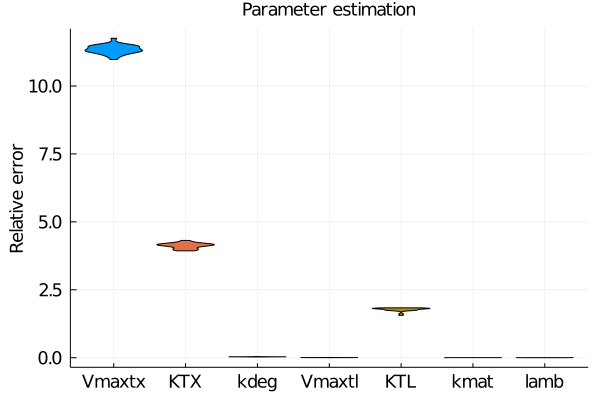

In [71]:
#Round 2

SWITCHTIMES = [0.8, 0.1, 0.5, 0.9, 0.7]
IniPara = Para_after_first_round
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
online = 2
INPOP = ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)


EST_PARA = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    EST_PARA[j, :] = i
    j += 1
end
REL_ER = RelativeError(PARAMS, EST_PARA)
PLOTNAME = "AAA  round 2"
violin( xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]),label = false, REL_ER, ylabel = "Relative error", title = "Parameter estimation" )

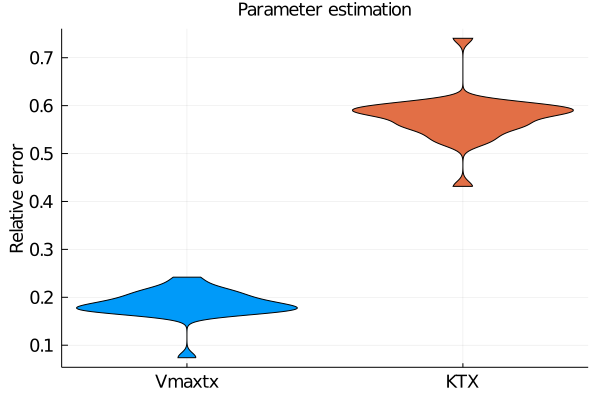

In [54]:
violin( xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl"]),label = false, REL_ER[:,6:7], ylabel = "Relative error", title = "Parameter estimation" )

In [50]:
#Checkpoint
for i in  REL_ER
    println(i)
end
#Log_mat = map!(REL_ER, log)

0.6206754252169061
0.6293142838954768
0.6575489571742346
0.6271048456394799
0.6593656150528902
0.5895615075450458
0.6213145912798594
3.7988102217144215
0.6330490167448272
0.5775333547178448
0.5853695828893511
0.6593771021224681
0.7067557449418687
0.6237323568538098
0.5677098089219569
0.6809423719281136
0.59120466187108
0.5893615584686573
0.6201156695782115
0.5603625932454984
0.6576494972943223
0.6513739724592079
0.6228361418016445
0.6281265836846932
0.5784667084928007
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
70.73635784667516
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.9900000000000001
0.8378073468593428
0.848028913879449
0.82522812309164

In [149]:
INPOP

Dict{Any,Any} with 25 entries:
  18 => [14.4963; 0.0365377; … ; 0.030352; 0.0204749]
  2  => [16.0914; 0.0379937; … ; 0.0303062; 0.0203288]
  16 => [14.8537; 0.0359477; … ; 0.0302213; 0.020471]
  11 => [14.8596; 0.036488; … ; 0.0303447; 0.0204526]
  21 => [13.8935; 0.0347171; … ; 0.0303035; 0.0204811]
  7  => [14.4663; 0.0358744; … ; 0.0302715; 0.0204667]
  9  => [14.881; 0.0356158; … ; 0.0302802; 0.0203447]
  25 => [14.4185; 0.042189; … ; 0.0307086; 0.0208539]
  10 => [14.7869; 0.0357112; … ; 0.0302984; 0.020493]
  19 => [14.4437; 0.0359986; … ; 0.0302389; 0.0204905]
  17 => [14.6739; 0.036112; … ; 0.030342; 0.020492]
  8  => [14.6094; 0.0364275; … ; 0.0303186; 0.0204026]
  22 => [14.504; 0.0355508; … ; 0.0303373; 0.0204973]
  6  => [14.7686; 0.0353505; … ; 0.0302869; 0.0204122]
  24 => [15.6876; 0.0379978; … ; 0.0303078; 0.0206893]
  4  => [14.4546; 0.0358501; … ; 0.030253; 0.0204678]
  3  => [14.6731; 0.0373071; … ; 0.0302045; 0.0204818]
  5  => [14.4182; 0.0356135; … ; 0.0302408; 0

In [288]:
SWITCHTIMES = [0.9, 0.9, 0.3, 0.0, 0.6, 0.0]
TMAX = 200
INTERVAL_DIL = 100
SWITCHTIMES =[0.1]
test_trace = Trace_sim(INPOP,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
naive_ref = add_gauss(naive_ref, 0.05)
naive_ref = Positive(naive_ref)
PLOTNAME =  "AAA Fig2 t100 d01 trace.svg"
plot()
plot!(test_trace[3,:], label = "Mean", c=:red1)
plot!(naive_ref, label = "Ref", c=:black)
plot!(test_trace[1,:], label = false, c=:orange)
plot!(test_trace[5,:], c=:red2, label = false )
plot!(test_trace[2,:], fillrange=[test_trace[1,:], test_trace[2,:]], fillalpha=0.3, c=:orange, label= "Min-Max")
plot!(test_trace[4,:], fillrange=[test_trace[5,:], test_trace[4,:]], fillalpha=0.3, c=:red2, label  = "Std", xticks=false)
yaxis!("[Pmat]")
xaxis!("t")
savefig(PATH_TO_OUTPUT*PLOTNAME)

In [141]:
plot()
plot!(SimPmat(model!,u0, INPOP[7],TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES))
plot!(naive_ref)
for i in keys(INPOP)
    println(i," " , Score(INPOP[i],naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES))
end

18 2.7852478268840746
2 1.4758931615226303
16 2.3856956733144647
11 1.8428729642589117
21 6.8578633345034845
7 1.6779704663249435
9 1.7795208087810188
25 10.479235320021607
10 1.827399568800918
19 3.281920800315489
17 2.711853065277527
8 1.7640665703965124
22 8.331241516547816
6 1.6645837342715386
24 9.751678296782437
4 1.6070667676372485
3 1.6007246024516861
5 1.6226728060751574
20 3.4564569196625183
23 9.38257387418997
13 1.9240451552462174
14 1.9949922229394004
15 2.1279908067716353
12 1.9110467308378576
1 1.366533588154299


In [130]:
INPOP=Rank(INPOP, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)

Dict{Any,Any} with 25 entries:
  18 => [4.01981, 0.104419, 0.107503, 1.04955, 0.913548, 0.0180574, 0.0295762]
  2  => [4.86761, 0.12553, 0.050011, 0.528522, 0.1918, 0.0179868, 0.057645]
  16 => [6.52859, 0.107639, 0.042897, 0.644493, 0.0133696, 0.0139865, 0.13402]
  11 => [6.40223, 0.0813297, 0.0367683, 0.555648, 0.0396771, 0.0149899, 0.11075…
  21 => [4.18535, 0.113627, 0.110062, 1.00204, 0.90887, 0.0192854, 0.0317872]
  7  => [6.16155, 0.0537172, 0.044955, 0.576498, 0.0965183, 0.0165167, 0.107684]
  9  => [6.42075, 0.0498743, 0.0317505, 0.522305, 0.0764895, 0.01626, 0.109746]
  25 => [7.73632, 0.0226003, 0.0337301, 0.462942, 0.110484, 0.0272001, 0.193453]
  10 => [6.36532, 0.0710738, 0.0386798, 0.563877, 0.0458562, 0.0152316, 0.11393…
  19 => [6.10196, 0.107297, 0.0418337, 0.77589, 0.0137069, 0.0149214, 0.175197]
  17 => [6.4003, 0.023672, 0.0330755, 0.570492, 0.111093, 0.0173345, 0.132632]
  8  => [6.85079, 0.0382926, 0.0360838, 0.400208, 0.078533, 0.0163753, 0.082314…
  22 => [6.26

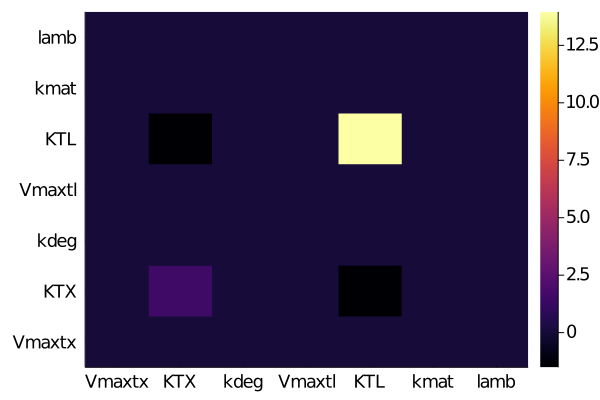

In [70]:
PLOTNAME = "Covariance matrix of all parameter n=10 s=20"
plot()
heatmap!(cov(REL_ER),xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]), yticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]))
#savefig(PATH_TO_OUTPUT*PLOTNAME)

In [71]:
PARA_VAL = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    PARA_VAL[j, :] = i
    j += 1
end
CORRPARA = PARA_VAL[:, 1:5]
PLOTNAME = "Correlation on 5 first parameters bigVar"
corrplot(CORRPARA, label = ["Vmaxtx","KTX","kdeg","Vmaxtl","KTL"], size =(1800, 1500))
#savefig(PATH_TO_OUTPUT*PLOTNAME)

LoadError: InexactError: trunc(Int64, NaN)

The following are valid modifications of the experimental program:

* increase number of experimental stages
* change dilution interval
* pure dilution (without refreshing DNA and activity)
* change input DNA concentration 
* measure mRNA simultaneously with Pmat

More complex devices can also change dilution fraction but we don't yet have those in the lab.

## 2.1 ESS

The method is based on population selection. Each member of the population generate child with the other memebers of the population and the best one is selected for the next generation. Furthermore, an intensification is used with the function go_beyond if the child obtain a better score than the parent.

The score is defined as the squared norm between the simulation with the infered parameters and the experimental simulation.

### Functions

In [4]:
# The rank function is used on the pop dictionary ('Number of the sample' => '[Values of the parameters]) and will return the pop Dict with sample number corresponding to the score of the parameters.

function Rank(pop, ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    temp_dict = Dict()
    for i in values(pop)
        #run simulation here
        temp_dict[i] = Score(i, ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    end
    FINPOP = Dict()

    LISTKEYS = []
    for i in keys(temp_dict)
        append!(LISTKEYS, [i])
    end 

    j = 1
    for i in LISTKEYS
        FINPOP[j]=findmin(temp_dict)[2]
        delete!(temp_dict, findmin(temp_dict)[2])
        j+=1
    end
    return FINPOP    
end

function Positive(list)
    j = 1
    for i in list
        if i <= 0
            list[j] = 0.0001
        end
        j +=1
    end
    return list
end


# The function SimPmat simulate the microfluidic experiment but only return the values of Pmat

function SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    if length(SWITCHTIMES)==1
        solU, SolDU = solvemodel(model!,u0,PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES);
        Pmat = [datum for subarr in solU.u for datum in subarr[idx_Pmat]];
        return Pmat
    else 
        solU, SolDU = solvemodel_frac(model!,u0,PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES);
        Pmat = [datum for subarr in solU.u for datum in subarr[idx_Pmat]];
        return Pmat
    end
end

# The function Confronte take the parameters from two samples and pick a child inside of the hypersquared defined by the two 'parents'

function Confronte(x1, x2, i, j)
    #Generation of a 'child' inside of the hypersquare
    d = (x2 .- x1)/2
    beta = (abs(j-i)-1)/(POPSIZE-2)
    R = rand(Float64,(NPARAM,1))
    if i<j
        alpha = 1
    else
        alpha = -1
    end
    c1 = x1  .- d*(1+alpha*beta)
    c2 = x2 .+ d*(1-alpha*beta)
    CHILD = c1+(c2-c1) .* R
    CHILD = Positive(CHILD)
    return CHILD
end

# The Score function compute the simulation with a liste of parameters as an input and return the corresponding squared distance with the reference simulation

function Score(x, ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    score = SimPmat(model!,u0, x,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    return norm(score - ref)
end

function go_beyond(x_bestch, x_par, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    x_ch =x_bestch
    x_pr = x_par
    improve = 1
    A = 1
    while Score(x_ch, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)<Score(x_pr, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
        x_temp = x_ch .- (x_pr -x_ch) ./ A
        x_temp = Positive(x_temp)
        x_pr = x_ch
        if Score(x_temp, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES) <= Score(x_ch, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
            x_ch = x_temp
        else
            return x_ch
        end
        improve += 1
        if improve == 2
            A = A/2
            improve = 0
        end
    return x_ch
    end     
end

function Get_final_State(FinPop)
    PARAM = Array{Tuple{Float64,Float64},1}()
    for i in 1:size(FinPop)[2]
        pop_min = maximum(FinPop[:,i])
        pop_max =  minimum(FinPop[:,i])
        New_Para = [(pop_min, pop_max)]
        append!(PARAM,New_Para)
    end
    return PARAM
end            

function Score_OED_Dcrit(INPOP)
    EST_PARA = zeros(Float64, length(keys(INPOP)), 7)
    j = 1
    for i in values(INPOP)
        EST_PARA[j, :] = i
        j += 1
    end
    COV = cov(EST_PARA)
    #COV = inv(COV)
    return det(COV)
end

function Score_OED_Ecrit(INPOP)
    PARA_VAL = zeros(Float64, POPSIZE, 7)
    j = 1
    for i in values(INPOP)
        PARA_VAL[j, :] = i
        j += 1
    end
    COVMATRIX = cov(PARA_VAL)
    #COVMATRIX = inv(COVMATRIX)
    EIGENVAL = eigvals(COVMATRIX)
    MIN = EIGENVAL[1]
    MAX = EIGENVAL[length(EIGENVAL)]
    ECRIT = MIN/MAX
end

function OED_V0(NB_PHASES)
    BEST_SCORE = 1
    BEST_DESIGN = []
    DESIGN_SPACE = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    for i in 1:20
        DESIGN = shuffle!(DESIGN_SPACE)
        DESIGN = DESIGN[1:NB_PHASES]
        SWITCHTIMES = DESIGN
        naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
        INPOP_rd = ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)
        SCORE = Score_OED_Dcrit(INPOP_rd)
        if SCORE<BEST_SCORE
            BEST_SCORE = SCORE
            BEST_DESIGN = DESIGN
        end
    end
    return BEST_SCORE,BEST_DESIGN
end

function Trace_sim(INPOP,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)

    SIM = SimPmat(model!,u0, INPOP[1],TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    SIM_MAT = zeros(Float32,length(keys(INPOP)),length(SIM))
    STAT_MAT = zeros(Float32, 5,length(SIM))

    for i in keys(INPOP)
        SIM = SimPmat(model!,u0, INPOP[i],TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
        SIM_MAT[i,:] = SIM
    end
    for i in 1:size(SIM_MAT)[2]
        temp_list = SIM_MAT[:,i]
        STAT_MAT[1,i] = minimum(temp_list)
        STAT_MAT[2,i] = maximum(temp_list)
        STAT_MAT[3,i] = mean(temp_list)
        STAT_MAT[4,i] = mean(temp_list) .+ std(temp_list)
        STAT_MAT[5,i] = mean(temp_list) .- std(temp_list)
    end

return STAT_MAT
end

function ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online ,IniPara)

    NPARAM = length(PARA_ref)
    plan, _= LHCoptim(10*NPARAM, NPARAM, 0)
    if online ==1
        PARAM = SET_PARAM(PARA_ref, PARA_var)
    elseif online ==2
        PARAM = IniPara
        println(PARAM)
    end

##  Initialisation:
    #Generate the Latin Hypercube Sampling
    scaled_plan = scaleLHC(plan,PARAM)
    scaled_plan = scaleLHC(plan,PARAM)
    Selec_dict = Dict()

    #The first loop will simulate insilico experiment with 70 parameters values and return the best 20 results with the L2 norm as a cost function

    for i in 1:size(scaled_plan,1)
        score = Score(scaled_plan[i, :], naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
        Selec_dict[i] = score
    end


#Select the POPSIZE best entries by increasing score
    INPOP = Dict()
    j = 1
    while j<=POPSIZE
        INPOP[j] = scaled_plan[findmin(Selec_dict)[2], :]
        delete!(Selec_dict, findmin(Selec_dict)[2])
        j+=1
    end

##  Main loop:
    h = 1
    while Score(INPOP[POPSIZE],naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES) >= 0.01
    println("Generation ",h)
    println("Best score:",Score(INPOP[1],naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES), " Worst score:", Score(INPOP[POPSIZE],naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES))
    h+=1
    if h==200
        return INPOP
    end
    if 1 - Score(INPOP[1],naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)/Score(INPOP[POPSIZE],naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)<=0.05
        return INPOP
    end

    for i in keys(INPOP)
        x1 = INPOP[i]
        SCORES_CH = Dict()
        for j in keys(INPOP)
            if i != j
                x2 = INPOP[j]
                x_ch = Confronte(x1, x2, i, j)
                #simulate x_ch and run go_beyond if x_ch has a better score as its parents
                score_ch = Score(x_ch, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
                SCORES_CH[score_ch]=x_ch
            end
        end
        Temp_list=[]
        for t in keys(SCORES_CH)
            append!(Temp_list, t)
        end
        best_ch = findmin(Temp_list)[1]
        x_bestch = SCORES_CH[best_ch]

        if Score(x_bestch, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)<Score(x1, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
            x1 = go_beyond(x_bestch, x1,naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
            INPOP[i] = x1
        end
        INPOP= Rank(INPOP, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    end
    end
return INPOP
end

#Function to set the parameters that will change and those who won't. Take as input a vector with 1 if the parameter vary and 0 otherwise. Return an array with the range of each parameter.

function SET_PARAM(PARA_ref, PARA_var)
    PARAM = Array{Tuple{Float64,Float64},1}()
    for i in 1:length(PARA_ref)
        if PARA_var[i]==1
            BOUNDS = [(PARA_ref[i]/10,PARA_ref[i]*10)]
            append!(PARAM,BOUNDS)
        elseif PARA_var[i]==2
                False_val=(rand(1:1000)/500)*PARA_ref[i]
                BOUNDS = [(False_val,False_val)]
                append!(PARAM,BOUNDS)
        else
            BOUNDS =[(PARA_ref[i],PARA_ref[i])]
            append!(PARAM,BOUNDS)
        end
    end
println(PARAM)
return PARAM
end


#Finding the best child must be corrected
function ESS_par(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref)

    NPARAM = length(PARA_ref)
    plan, _= LHCoptim(10*NPARAM, NPARAM, 0)

    PARAM = SET_PARAM(PARA_ref, PARA_var)

##  Initialisation:
    #Generate the Latin Hypercube Sampling
    scaled_plan = scaleLHC(plan,PARAM)
    scaled_plan = scaleLHC(plan,PARAM)
    Selec_dict = Dict()

    #The first loop will simulate insilico experiment with 70 parameters values and return the best 20 results with the L2 norm as a cost function

    for i in 1:size(scaled_plan,1)
        score = Score(scaled_plan[i, :], naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
        Selec_dict[i] = score
    end


#Select the POPSIZE best entries by increasing score
    INPOP = Dict()
    j = 1
    while j<=POPSIZE
        INPOP[j] = scaled_plan[findmin(Selec_dict)[2], :]
        delete!(Selec_dict, findmin(Selec_dict)[2])
        j+=1
    end

##  Main loop:

    for h in 1:NBGEN
    println("Generation ",h," on ",NBGEN)
    Threads.@threads for i in 1:POPSIZE
        println("First checkpoint")
        INPOPb = copy(INPOP)
        x1 = INPOPb[i]
        SCORES_CH = Dict()
        for j in keys(INPOPb)
        println("Second checkpoint")
            if i != j
                x2 = INPOPb[j]
                x_ch = Confronte(x1, x2, i, j)
                #simulate x_ch and run go_beyond if x_ch has a better score as its parents
                score_ch = Score(x_ch, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
                SCORES_CH[score_ch]=x_ch
            end
        end
        x_bestch = findmin(SCORES_CH)[1]
        if Score(x_bestch, naive_ref)<Score(x1, naive_ref)
            x1 = go_beyond(x_bestch, x1, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
            INPOP[i] = x1
        end
    end
    Rank(INPOP, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    end
return INPOP
end

function RelativeError(REF_PARA, EST_PARA)
    REL_ERROR = copy(EST_PARA)
    j = 1
    for i in 1:size(EST_PARA)[1]
        REL_ERROR[j,:] = map(x -> abs(x), EST_PARA[i,:] .- REF_PARA) ./ REF_PARA
        j += 1
    end
return REL_ERROR
end

function SumRelativeError(REF_PARA, EST_PARA)
    REL_ERROR = copy(EST_PARA)
    for i in 1:length(EST_PARA)
        REL_ERROR[i] = abs( EST_PARA[i] - REF_PARA[i]) / REF_PARA[i]
    end
return sum(REL_ERROR)/7
end


SumRelativeError (generic function with 1 method)

In [12]:
DICTIONARY=Dict(1=>3, 2=>2, 0.2=>3)
findmin(DICTIONARY[1])
Temp_list=[]
for i in keys(DICTIONARY)
    append!(Temp_list, i)
end
findmin(Temp_list)[1]
println(DICTIONARY[findmin(Temp_list)[1]])

3


In [93]:
PARA_var= [1,1,0,0,1,1,0]
TEST2=OED_V0(5)

5328438773720184
Generation 14 on 20
Best score:0.0002556898559320511 Worst score:0.045328438773720184
Generation 15 on 20
Best score:0.0002556898559320511 Worst score:0.03638928861049487
Generation 16 on 20
Best score:0.0002556898559320511 Worst score:0.03638928861049487
Generation 17 on 20
Best score:0.0002556898559320511 Worst score:0.03638928861049487
Generation 18 on 20
Best score:0.0002556898559320511 Worst score:0.03638928861049487
Generation 19 on 20
Best score:0.0002556898559320511 Worst score:0.03638928861049487
Generation 20 on 20
Best score:0.0002556898559320511 Worst score:0.03638928861049487
[(0.1, 10.0), (0.001, 0.1), (0.01, 0.01), (0.1, 0.1), (0.01, 1.0), (0.003, 0.3), (0.02, 0.02)]
Generation 1 on 20
Best score:0.6659740428752079 Worst score:8.489615686442043
Generation 2 on 20
Best score:0.0696695572865557 Worst score:8.483855855136557
Generation 3 on 20
Best score:0.038693448742024045 Worst score:8.332498371416069
Generation 4 on 20
Best score:0.006665205305163055 Wo

(0.0, [0.3, 0.8, 0.7, 0.2, 0.5])

In [ ]:
[0.3, 0.8, 0.7, 0.2, 0.5]

In [221]:
Score_OED_Dcrit(INPOP)

5.872389136504348e-22

## Selective tree

Iterative method to select the best possible design with different optimality criteria.

In [57]:
function Selective_tree(Nb_stages,PARA_var)
    #Fracts=collect(0.1:0.1:0.9)
    Fracts=[0.00,0.3,0.6,0.8]
    SWITCHTIMES = []
    Def_Switch = []
    T_inter = 60.
    INTERVAL_DIL = 20.
    for i in 1:Nb_stages
        println("Stage ",i," on ",Nb_stages)
        Score=1
        Dil=0.5
        TMAX=i*T_inter
        TSAVE = collect(0:2:TMAX)
        for j in Fracts
            SWITCHTIMES=copy(Def_Switch)
            append!(SWITCHTIMES,j)
            naive_ref=SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
            INPOP=ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)
            Temp_score = Score_OED_Dcrit(INPOP)
            if Temp_score<Score 
                Score = Temp_score
                Dil=j
            end
            
        end
    append!(Def_Switch,Dil)    
    end
    return Def_Switch
end

        



Selective_tree (generic function with 1 method)

In [58]:
Nb_stages=6
POPSIZE=25
NBGEN=20
PARA_var=[1,1,1,1,1,1,1]
#PARA_var= [1,1,0,0,1,1,0]
Test1  = Selective_tree(Nb_stages,PARA_var)

295473537326 Worst score:0.09270123886227781
Generation 142
Best score:0.0029762295473537326 Worst score:0.09270123886227781
Generation 143
Best score:0.0029762295473537326 Worst score:0.09270123886227781
Generation 144
Best score:0.0029762295473537326 Worst score:0.09270123886227781
Generation 145
Best score:0.0029762295473537326 Worst score:0.09270123886227781
Generation 146
Best score:0.0029762295473537326 Worst score:0.09270123886227781
Generation 147
Best score:0.0029696335068210853 Worst score:0.09270123886227781
Generation 148
Best score:0.0029696335068210853 Worst score:0.09270123886227781
Generation 149
Best score:0.002860598919283623 Worst score:0.09270123886227781
Generation 150
Best score:0.002860598919283623 Worst score:0.09270123886227781
Generation 151
Best score:0.0028545627270406436 Worst score:0.09270123886227781
Generation 152
Best score:0.0028545627270406436 Worst score:0.09270123886227781
Generation 153
Best score:0.002816904708420012 Worst score:0.0927012388622778

6-element Array{Any,1}:
 0.3
 0.6
 0.3
 0.3
 0.0
 0.6

In [59]:
Test1

6-element Array{Any,1}:
 0.3
 0.6
 0.3
 0.3
 0.0
 0.6

## Accuracy of the plot, visual approach

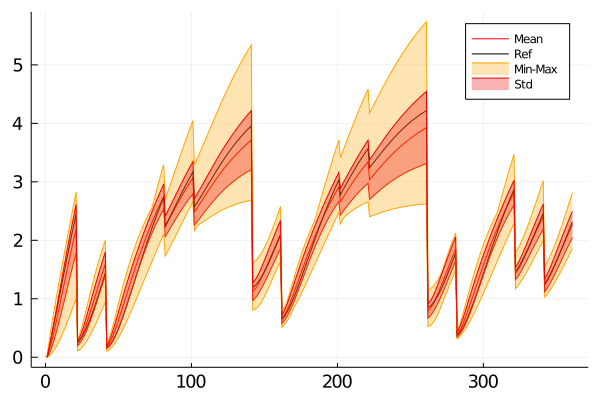

In [189]:
test_trace = Trace_sim(INPOP)

PLOTNAME = "Fit variation with variations 100 generations"
plot()
plot!(test_trace[3,:], label = "Mean", c=:red1)
plot!(naive_ref, label = "Ref", c=:black)
plot!(test_trace[1,:], label = false, c=:orange)
plot!(test_trace[5,:], c=:red2, label = false )
plot!(test_trace[2,:], fillrange=[test_trace[1,:], test_trace[2,:]], fillalpha=0.3, c=:orange, label= "Min-Max")
plot!(test_trace[4,:], fillrange=[test_trace[5,:], test_trace[4,:]], fillalpha=0.3, c=:red2, label  = "Std")
#savefig(PATH_TO_OUTPUT*PLOTNAME)

## Show the trace of the fits

The aim of this part is to determine whether the extreme values of parameters come with bad fits. This will indicate if the issue is identifiability or fitting. 

1- Run ESS with controlled initial parameter values 

2- Compute the simulation for all member of the final population 

3- Plot 

### Multithreading version of ESS

In [88]:
NPARAM = 7
POPSIZE = 20
NBGEN = 10
PARA_ref = copy(PARAMS)
PARA_var = ones(7,1)

naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
@time begin
INPOP = ESS_par(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref)
end

[(0.1, 10.0), (0.001, 0.1), (0.001, 0.1), (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation 1 on 10


LoadError: TaskFailedException:
MethodError: no method matching firstindex(::Base.KeySet{Any,Dict{Any,Any}})
Closest candidates are:
  firstindex(!Matched::TRef, !Matched::Any...) at /root/.julia/packages/Libtask/00Il9/src/tref.jl:86
  firstindex(!Matched::Cmd) at process.jl:638
  firstindex(!Matched::Core.SimpleVector) at essentials.jl:599
  ...
Stacktrace:
 [1] (::var"#1401#threadsfor_fun#20"{Array{Float64,1},Dict{Any,Any},Base.KeySet{Any,Dict{Any,Any}}})(::Bool) at ./threadingconstructs.jl:66
 [2] (::var"#1401#threadsfor_fun#20"{Array{Float64,1},Dict{Any,Any},Base.KeySet{Any,Dict{Any,Any}}})() at ./threadingconstructs.jl:48

In [158]:
NPARAM = 7
POPSIZE = 20
NBGEN = 100
PARA_ref = copy(PARAMS)
PARA_var = ones(7,1)
#PARA_var= [1,0,0,0,0,0,0]
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
@time begin
INPOP = ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref)
end


[(0.1, 10.0), (0.001, 0.1), (0.001, 0.1), (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation 1 on 100
Generation 2 on 100
Generation 3 on 100
Generation 4 on 100
Generation 5 on 100
Generation 6 on 100
Generation 7 on 100
Generation 8 on 100
Generation 9 on 100
Generation 10 on 100
Generation 11 on 100
Generation 12 on 100
Generation 13 on 100
Generation 14 on 100
Generation 15 on 100
Generation 16 on 100
Generation 17 on 100
Generation 18 on 100
Generation 19 on 100
Generation 20 on 100
Generation 21 on 100
Generation 22 on 100
Generation 23 on 100
Generation 24 on 100
Generation 25 on 100
Generation 26 on 100
Generation 27 on 100
Generation 28 on 100
Generation 29 on 100
Generation 30 on 100
Generation 31 on 100
Generation 32 on 100
Generation 33 on 100
Generation 34 on 100
Generation 35 on 100
Generation 36 on 100
Generation 37 on 100
Generation 38 on 100
Generation 39 on 100
Generation 40 on 100
Generation 41 on 100
Generation 42 on 100
Generation 43 on 100
Generation

Dict{Any,Any} with 20 entries:
  18 => [7.64598, 0.0768749, 0.0460819, 0.640446, 0.000321023, 0.0110026, 0.125…
  2  => [1.10435, 0.0569565, 0.0583913, 0.397391, 0.942609, 0.0761739, 0.010608…
  16 => [7.82462, 0.0760077, 0.0458253, 0.70654, 0.000214117, 0.0114409, 0.1530…
  11 => [7.16456, 0.0682473, 0.0308679, 0.398293, 0.00643405, 0.00892895, 0.067…
  7  => [7.04263, 0.0673088, 0.0399466, 0.461097, 0.0001, 0.0113622, 0.0939813]
  9  => [7.04304, 0.0673088, 0.0399355, 0.461096, 0.0001, 0.0113623, 0.0938676]
  10 => [6.86457, 0.073625, 0.0466159, 0.428865, 0.0001, 0.010958, 0.0836168]
  19 => [8.35575, 0.0748686, 0.0483195, 0.817743, 0.0001, 0.0122197, 0.182018]
  17 => [6.9213, 0.0720873, 0.0338537, 0.410727, 0.0210375, 0.0108771, 0.074220…
  8  => [3.34803, 0.0896023, 0.0742689, 0.532913, 0.258567, 0.0163691, 0.039372…
  6  => [6.92107, 0.0726281, 0.0337917, 0.410346, 0.0242725, 0.0113703, 0.07125…
  4  => [8.13432, 0.0988108, 0.0205409, 0.32754, 0.0907498, 0.0152806, 0.057437…
  3 

## 2.2 Inintial population with local fit

Firsts attempts with local fit on each dilution intervale and then with annealing. (Think about time!)

In [14]:
PLOTNAME = "Introduction of noise in simulated experiment"
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
naive_ref_noisy_5 = add_gauss(naive_ref, 0.05) .+ 1
naive_ref_noisy_10 = add_gauss(naive_ref, 0.10) .+2
naive_ref_noisy_5 = Positive(naive_ref_noisy_5)
naive_ref_noisy_10 = Positive(naive_ref_noisy_10)
p = plot(grid=:false,legend=:true,framestyle=:frame,size=(600,400))
plot!(t,naive_ref, lw=2, labels="Pmat") 
plot!(t,naive_ref_noisy_5, lw=2, labels="Pmat_noisy 5%")
plot!(t,naive_ref_noisy_10, lw=2, labels="Pmat_noisy 10%") 
savefig(PATH_TO_OUTPUT*PLOTNAME)


LoadError: UndefVarError: TSAVE not defined

In [157]:
#Generate 10*number of parameters sample with every sample having its own parameter value
#In this first example, n=7 then there is 70 samples
NPARAM = 7
POPSIZE = 20
STOPCRIT = 0.00001
plan, _= LHCoptim(10*NPARAM, NPARAM, 0)

#Then with scaleLHC, each parameter is set in the confidence intervale to be explored (for the moment, those values are between -5 and 5 for all the parameters)
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
#Add noise to the simulated experiment
naive_ref = add_gauss(naive_ref, 0.15)
naive_ref = Positive(naive_ref)

361-element Array{Float64,1}:
 0.2792753076791409
 0.13466302714842174
 0.24365868316967276
 0.5042408059190637
 0.4521106999313729
 0.45501451509706436
 1.018990465576142
 0.5903217808404754
 0.7590623390750669
 0.9633351101464488
 1.1582785382005767
 1.567472103695736
 1.3443619381776524
 ⋮
 0.7994044843288114
 0.8950828350299253
 1.1587278178264269
 1.0633311931555132
 1.4134039835232866
 1.2538889096913426
 1.2514337043298405
 1.419902202411036
 1.5212966365426384
 1.7077602606470037
 1.7473971250556266
 1.6571405322270072

In [19]:
#Medium (scale 10)
PARAM = [(0.1,10.),(0.001,0.1),(0.001,0.1),(0.01,1.0),(0.01,1.0),(0.003,0.3),(0.002,0.2)]

#PARAM = [(0.1,10.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.1,0.1),(0.03,0.03),(0.02,0.02)]

#PARAM = [(1.,1.),(0.001,0.1),(0.01,0.01),(0.1,0.1),(0.1,0.1),(0.03,0.03),(0.02,0.02)]

#PARAM = [(1.,1.),(0.01,0.01),(0.001,0.1),(0.1,0.1),(0.1,0.1),(0.03,0.03),(0.02,0.02)]

#PARAM = [(1.,1.),(0.01,0.01),(0.01,0.01),(0.01,1.0),(0.1,0.1),(0.03,0.03),(0.02,0.02)]

#PARAM = [(1.,1.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.01,1.0),(0.03,0.03),(0.02,0.02)]

#PARAM = [(1.,1.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.1,0.1),(0.003,0.03),(0.02,0.02)]

#PARAM = [(1.,1.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.1,0.1),(0.03,0.03),(0.002,0.2)]

#Fix all the highly variating parameters
#PARAM = [(1.,1.),(0.01,0.01),(0.001,0.1),(0.01,1.0),(0.1,0.1),(0.003,0.3),(0.02,0.02)]

#Two opposit free parameters
#PARAM = [(0.1,10.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.01,1.0),(0.03,0.03),(0.02,0.02)]

#Three opposit free parameters
#PARAM = [(0.1,10.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.01,1.0),(0.03,0.03),(0.002,0.2)]

#Opposite behavior

#PARAM = [(0.1,10.),(0.01,0.01),(0.01,0.01),(0.1,0.1),(0.1,0.1),(0.003,0.3),(0.02,0.02)]

#PARAM = [(0.1,10.),(0.01,0.01),(0.001,0.1),(0.1,0.1),(0.1,0.1),(0.003,0.3),(0.02,0.02)]

PARAM = [(1.,1.),(0.01,0.01),(0.001,0.1),(0.1,0.1),(0.1,0.1),(0.03,0.03),(0.002,0.2)]

#High
#PARAM = [(0.1,3.),(0.001,1.),(0.1,3.),(0.1,3.),(0.1,3.),(0.1,3.),(0.1,3.)]
#Generate the Latin Hypercube Sampling
scaled_plan = scaleLHC(plan,PARAM)
scaled_plan = scaleLHC(plan,PARAM)
Selec_dict = Dict()

#The first loop will simulate insilico experiment with 70 parameters values and return the best 20 results with the L2 norm as a cost function
for i in 1:size(scaled_plan,1)
    score = Score(scaled_plan[i, :], naive_ref)
    Selec_dict[i] = score
end


#Select the POPSIZE best entries by increasing score
INPOP = Dict()
j = 1
while j<=POPSIZE
    INPOP[j] = scaled_plan[findmin(Selec_dict)[2], :]
    delete!(Selec_dict, findmin(Selec_dict)[2])
    j+=1
end
t0POP = copy(INPOP)
INPOP= Rank(INPOP,naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)

  1.809797 seconds (5.69 M allocations: 154.504 MiB, 3.39% gc time)


Dict{Any,Any} with 20 entries:
  18 => [1.0, 0.01, 0.0096087, 0.1, 0.1, 0.03, 0.0565217]
  2  => [1.0, 0.01, 0.013913, 0.1, 0.1, 0.03, 0.0134783]
  16 => [1.0, 0.01, 0.0598261, 0.1, 0.1, 0.03, 0.0393043]
  11 => [1.0, 0.01, 0.00530435, 0.1, 0.1, 0.03, 0.0364348]
  7  => [1.0, 0.01, 0.0813478, 0.1, 0.1, 0.03, 0.0163478]
  9  => [1.0, 0.01, 0.0110435, 0.1, 0.1, 0.03, 0.0335652]
  10 => [1.0, 0.01, 0.0354348, 0.1, 0.1, 0.03, 0.0278261]
  19 => [1.0, 0.01, 0.021087, 0.1, 0.1, 0.03, 0.0536522]
  17 => [1.0, 0.01, 0.0426087, 0.1, 0.1, 0.03, 0.0450435]
  8  => [1.0, 0.01, 0.0727391, 0.1, 0.1, 0.03, 0.0192174]
  6  => [1.0, 0.01, 0.0282609, 0.1, 0.1, 0.03, 0.022087]
  4  => [1.0, 0.01, 0.0368696, 0.1, 0.1, 0.03, 0.0106087]
  3  => [1.0, 0.01, 0.0397391, 0.1, 0.1, 0.03, 0.00773913]
  5  => [1.0, 0.01, 0.0684348, 0.1, 0.1, 0.03, 0.00486957]
  20 => [1.0, 0.01, 0.0698696, 0.1, 0.1, 0.03, 0.047913]
  13 => [1.0, 0.01, 0.0182174, 0.1, 0.1, 0.03, 0.0421739]
  14 => [1.0, 0.01, 0.00243478, 0.1, 0.1, 

In [14]:
for h in 1:10
println(h)
    for i in keys(INPOP)
        x1 = INPOP[i]
        SCORES_CH = Dict()
        for j in keys(INPOP)
            if i != j
                x2 = INPOP[j]
                x_ch = Confronte(x1, x2, i, j)
                #simulate x_ch and run go_beyond if x_ch has a better score as its parents
                score_ch = Score(x_ch, naive_ref)
                SCORES_CH[x_ch]=score_ch
            end
        end
        x_bestch = findmin(SCORES_CH)[2]
        if Score(x_bestch, naive_ref)<Score(x1, naive_ref)
            x1 = go_beyond(x_bestch, x1)
            INPOP[i] = x1
        end
        INPOP= Rank(INPOP, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    end
    end

1


LoadError: UndefVarError: INPOP not defined

In [16]:
#Follow the evolution of the best worst and mean value per parameter
TOP1 = []
TOP5 = []
FLOP1 = []
FLOP5 = []
MEANPOP = []


#We create a matrix with general relative error for differente sizes of population
POPS = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25]
SPEC_MAT = zeros(Float32,20,length(POPS))
t = 1
INPOP = Dict()
for i in 1:5
INPOP[i] = t0POP[i]
end

for d in POPS
POPSIZE = d
INPOP[d] = t0POP[d]

for h in 1:10
    for i in keys(INPOP)
        x1 = INPOP[i]
        SCORES_CH = Dict()
        for j in keys(INPOP)
            if i != j
                x2 = INPOP[j]
                x_ch = Confronte(x1, x2, i, j)
                #simulate x_ch and run go_beyond if x_ch has a better score as its parents
                score_ch = Score(x_ch, naive_ref)
                SCORES_CH[x_ch]=score_ch
            end
        end
        x_bestch = findmin(SCORES_CH)[2]
        if Score(x_bestch, naive_ref)<Score(x1, naive_ref)
            x1 = go_beyond(x_bestch, x1)
            INPOP[i] = x1
        end
        INPOP= Rank(INPOP, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    end
println(d)
end
#append!(TOP1, [INPOP[1]])
#append!(FLOP1, [INPOP[20]])
for s in keys(INPOP)
SPEC_MAT[s,t]=SumRelativeError(PARAMS, INPOP[s])
end
t+=1
end

LoadError: UndefVarError: t0POP not defined

In [40]:
#We create a matrix with general relative error for differente sizes of population
POPS = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,22,23,24,25]
SPEC_MAT = zeros(Float32,length(POPS),25)
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
t = 1
for h in  POPS
    println(h)
    INPOP = ESS_seq(h, 10, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)
    for s in keys(INPOP)
        SPEC_MAT[t,s]=SumRelativeError(PARAMS, INPOP[s])
    end
    t+=1
end

5
[(0.1, 10.0), (0.001, 0.1), (0.001, 0.1), (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation 1 on 10
Best score:4.491931281781102 Worst score:7.895022400232867
Generation 2 on 10
Best score:4.491931281781102 Worst score:7.5984153362507545
Generation 3 on 10
Best score:2.1687041348567146 Worst score:7.5984153362507545
Generation 4 on 10
Best score:2.1687041348567146 Worst score:7.5984153362507545
Generation 5 on 10
Best score:2.1687041348567146 Worst score:6.615269944061323
Generation 6 on 10
Best score:0.8235538425429084 Worst score:5.899270079481374
Generation 7 on 10
Best score:0.8235538425429084 Worst score:4.530189987784189
Generation 8 on 10
Best score:0.7964030467757952 Worst score:3.2787578269583695
Generation 9 on 10
Best score:0.7964030467757952 Worst score:3.2787578269583695
Generation 10 on 10
Best score:0.5482048828375452 Worst score:2.754034588333809
6
[(0.1, 10.0), (0.001, 0.1), (0.001, 0.1), (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation

## Spectral plots

In [78]:
SPEC_MAT_backup = copy(SPEC_MAT)

20×16 Array{Float32,2}:
 12.5612   12.5612   12.7649   12.7649   …  12.7649   12.7649   12.7649
  5.189     5.189     5.189     1.82309      1.82309   1.82309   1.82309
  9.50326   9.50326  11.3191   10.9955      10.9955   10.9955   10.9955
 12.3308   12.3308   12.3003   12.3003      12.3003   12.3003   12.3003
  8.05077   8.05077   8.05077   8.05077      8.05077   8.05077   8.05077
  0.0       1.79493   1.8101    1.51642  …   1.51642   1.51642   1.51642
  0.0       0.0       6.69371   6.69371      6.32025   6.32025   6.32025
  0.0       0.0       0.0      11.6689      11.6689   11.6689   11.6689
  0.0       0.0       0.0       0.0          4.24138   4.26179   4.28587
  0.0       0.0       0.0       0.0          4.04112   4.04112   4.04112
  0.0       0.0       0.0       0.0      …   6.19765   6.19765   6.19765
  0.0       0.0       0.0       0.0          5.97458   5.97458   5.97458
  0.0       0.0       0.0       0.0         10.7831   10.7831   10.7831
  0.0       0.0       0.0       

In [123]:
SPEC_MAT = copy(SPEC_MAT_backup)

20×16 Array{Float32,2}:
 12.5612   12.5612   12.7649   12.7649   …  12.7649   12.7649   12.7649
  5.189     5.189     5.189     1.82309      1.82309   1.82309   1.82309
  9.50326   9.50326  11.3191   10.9955      10.9955   10.9955   10.9955
 12.3308   12.3308   12.3003   12.3003      12.3003   12.3003   12.3003
  8.05077   8.05077   8.05077   8.05077      8.05077   8.05077   8.05077
  0.0       1.79493   1.8101    1.51642  …   1.51642   1.51642   1.51642
  0.0       0.0       6.69371   6.69371      6.32025   6.32025   6.32025
  0.0       0.0       0.0      11.6689      11.6689   11.6689   11.6689
  0.0       0.0       0.0       0.0          4.24138   4.26179   4.28587
  0.0       0.0       0.0       0.0          4.04112   4.04112   4.04112
  0.0       0.0       0.0       0.0      …   6.19765   6.19765   6.19765
  0.0       0.0       0.0       0.0          5.97458   5.97458   5.97458
  0.0       0.0       0.0       0.0         10.7831   10.7831   10.7831
  0.0       0.0       0.0       

In [45]:
Stat_SPEC = zeros(Float32, 25, 5)

for i in 1:size(SPEC_MAT)[2]
Temp_List=[]

for j in SPEC_MAT[:,i]

if j > 0.0
append!(Temp_List, j)
end

end

Temp_List = convert(Array{Float32}, Temp_List)
println(Temp_List)
Stat_SPEC[i, 1] = maximum(Temp_List)
Stat_SPEC[i, 2] = minimum(Temp_List)
Stat_SPEC[i, 3] = mean(Temp_List)
Std_dev  = std(Temp_List)
Stat_SPEC[i, 4] = mean(Temp_List) + Std_dev
Stat_SPEC[i, 5] = mean(Temp_List) - Std_dev
end

Float32[1.4914778, 3.3676846, 2.1032052, 1.8333364, 2.759994, 1.455827, 3.63824, 6.27292, 2.9238884, 2.5169442, 5.4176598, 1.596222, 2.2330313, 5.853552, 2.5078962, 1.2003521, 1.9101988, 3.7977939, 2.9298491, 3.922709]
Float32[1.1004987, 3.384592, 3.0040674, 1.9456526, 3.1095114, 4.487759, 3.0656927, 7.237137, 4.087176, 2.6146739, 4.9855156, 3.129073, 2.7875614, 3.5814505, 1.7130655, 0.90656215, 2.622313, 3.9526165, 4.359382, 3.9765499]
Float32[1.3806678, 2.9343033, 2.580587, 4.1555343, 2.4353998, 3.0230331, 2.239213, 8.015588, 4.1921935, 2.597704, 5.1046944, 0.66778016, 4.014889, 3.2795591, 1.6991844, 1.846166, 1.5952901, 4.170433, 2.5506945, 4.166305]
Float32[1.9391012, 3.758735, 3.005801, 2.1345897, 2.799902, 3.4657795, 3.861652, 4.85747, 3.9832299, 2.6147082, 4.300823, 2.419085, 2.872403, 3.8261414, 1.8458614, 1.7687159, 2.834047, 4.531743, 4.349219, 5.122236]
Float32[2.9509978, 2.7176619, 2.4686778, 2.1321952, 2.8441954, 4.190045, 3.851974, 4.977691, 4.179006, 2.106179, 5.1382875,

LoadError: BoundsError: attempt to access 20×5 Array{Float32,2} at index [21, 1]

In [43]:
Stat_SPEC

25×5 Array{Float32,2}:
 6.27292  1.20035   2.98664    4.45707    1.51621
 7.23714  0.906562  3.30254    4.73125    1.87383
 8.01559  0.66778   3.13246    4.76002    1.5049
 5.12224  1.76872   3.31456    4.34847    2.28065
 5.13829  1.92734   3.22625    4.25605    2.19645
 5.71095  0.513515  3.28614    4.57349    1.99878
 5.67676  1.12895   3.29872    4.64879    1.94866
 5.50519  0.620376  3.41641    4.65296    2.17986
 5.11488  1.75903   3.43076    4.42383    2.4377
 6.09999  0.72653   3.51826    4.80896    2.22756
 5.60334  1.12518   3.81555    5.0872     2.54389
 5.33653  1.56579   3.25002    4.56048    1.93956
 5.73072  1.80317   3.94218    5.12243    2.76193
 5.20299  1.69807   3.22338    4.32352    2.12324
 5.80084  1.89934   3.56348    4.89801    2.22895
 5.58814  1.75342   3.69936    5.01864    2.38008
 5.93905  1.89543   3.85835    5.09639    2.6203
 8.20147  1.65214   4.42097    6.63065    2.2113
 5.58171  2.61255   3.87652    5.15627    2.59676
 6.11682  2.80492   4.11109    

In [129]:
Temp_List

LoadError: UndefVarError: Temp_List not defined

### Effect of population size

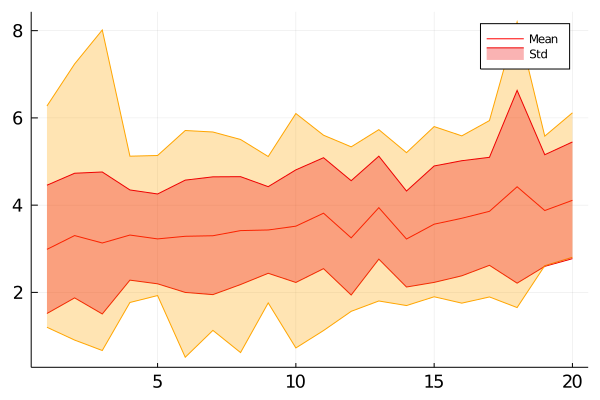

In [46]:
plot()
plot!(Stat_SPEC[:,3], label = "Mean", c=:red1)
plot!(Stat_SPEC[:,1], label = false, c=:orange)
plot!(Stat_SPEC[:,5], c=:red2,label = false )
plot!(Stat_SPEC[:,2], fillrange=[Stat_SPEC[:,1], Stat_SPEC[:,2]], fillalpha=0.3, c=:orange, label=false)
plot!(Stat_SPEC[:,4], fillrange=[Stat_SPEC[:,5], Stat_SPEC[:,4]], fillalpha=0.3, c=:red2, label  = "Std")

In [48]:

PLOTNAME = "AAA Effect of number of sample in the population "
plot()
plot!(POPS,Stat_SPEC[:,3], label = "Mean", c=:red1)
title!("Effect of population size on relative error")
#xaxis!(POPS, "Number of samples")
yaxis!("Relative error")
plot!(POPS,Stat_SPEC[:,1], label = false, c=:orange)
plot!(POPS,Stat_SPEC[:,5], c=:red2,label = false )
plot!(POPS,Stat_SPEC[:,2], fillrange=[Stat_SPEC[:,1], Stat_SPEC[:,2]], fillalpha=0.3, c=:orange, label=false)
plot!(POPS,Stat_SPEC[:,4], fillrange=[Stat_SPEC[:,5], Stat_SPEC[:,4]], fillalpha=0.3, c=:red2, label  = "Std")
savefig(PATH_TO_OUTPUT*PLOTNAME)


### Effect of time

In [28]:
#We create a matrix with general relative error for differente sizes of population
SPEC_MAT_time = zeros(Float32,POPSIZE,40)
naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
for h in 1:40
    println(h)
    INPOP = ESS_seq(POPSIZE, h, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)
    for s in keys(INPOP)
        SPEC_MAT_time[s,h]=SumRelativeError(PARAMS, INPOP[s])
    end
end

34
Best score:0.06747416463565517 Worst score:0.5941365453602215
Generation 22 on 34
Best score:0.06747416463565517 Worst score:0.394160015334191
Generation 23 on 34
Best score:0.06747416463565517 Worst score:0.3260707605295603
Generation 24 on 34
Best score:0.05377029076364781 Worst score:0.3153866255879695
Generation 25 on 34
Best score:0.05377029076364781 Worst score:0.3153866255879695
Generation 26 on 34
Best score:0.05377029076364781 Worst score:0.3153866255879695
Generation 27 on 34
Best score:0.05377029076364781 Worst score:0.3153866255879695
Generation 28 on 34
Best score:0.05377029076364781 Worst score:0.3153866255879695
Generation 29 on 34
Best score:0.052324655442662446 Worst score:0.3153866255879695
Generation 30 on 34
Best score:0.04076144462393736 Worst score:0.3153866255879695
Generation 31 on 34
Best score:0.04076144462393736 Worst score:0.3153866255879695
Generation 32 on 34
Best score:0.04076144462393736 Worst score:0.3153866255879695
Generation 33 on 34
Best score:0.

In [222]:

#We create a matrix with general relative error for differente sizes of population
SPEC_MAT_time = zeros(Float32,20,40)
for h in 1:40
println(h)
    for i in keys(INPOP)
        x1 = INPOP[i]
        SCORES_CH = Dict()
        for j in keys(INPOP)
            if i != j
                x2 = INPOP[j]
                x_ch = Confronte(x1, x2, i, j)
                #simulate x_ch and run go_beyond if x_ch has a better score as its parents
                score_ch = Score(x_ch, naive_ref)
                SCORES_CH[x_ch]=score_ch
            end
        end
        x_bestch = findmin(SCORES_CH)[2]
        if Score(x_bestch, naive_ref)<Score(x1, naive_ref)
            x1 = go_beyond(x_bestch, x1)
            INPOP[i] = x1
        end
        INPOP= Rank(INPOP, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
    end
for s in keys(INPOP)
SPEC_MAT_time[s,h]=SumRelativeError(PARAMS, INPOP[s])
end
end

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


In [32]:
SPEC_MAT_time

25×40 Array{Float32,2}:
 5.19654  2.03282  1.45736  3.85991  3.06582  …  0.675767  1.96955   2.17965
 2.54509  3.55808  2.33192  3.20865  2.66556     0.732051  1.37503   1.88239
 4.12065  2.80492  2.2343   3.61074  1.95202     0.737153  1.68943   1.91388
 3.01373  4.42928  3.42689  3.85409  1.55635     0.571244  1.74992   2.22228
 2.89439  3.51918  2.70003  2.99185  2.70861     0.662475  1.78328   2.38571
 4.04662  2.03733  4.25535  2.68278  2.0636   …  0.710292  1.68628   2.41319
 2.79827  4.37273  3.9477   2.93602  2.03926     0.674524  1.09484   2.44275
 2.90114  3.053    3.13464  3.09806  2.81183     0.57072   1.74866   2.45099
 2.44229  3.84908  3.8308   4.61634  4.96259     2.07571   1.75072   2.45033
 3.81247  3.04758  3.60959  6.00912  2.09343     2.2211    1.77042   2.2619
 3.99835  3.19578  3.1125   4.79394  2.33682  …  2.45045   1.72894   2.43308
 2.34969  2.79981  2.15114  3.78575  2.34945     2.86054   3.20706   2.43224
 2.62946  3.47359  3.37378  3.73129  2.29688     2.96

In [29]:
Stat_SPEC_time = zeros(Float32, 40, 5)

for i in 1:size(SPEC_MAT_time)[2]
Temp_List=[]

for j in SPEC_MAT_time[:,i]

if j > 0.0
append!(Temp_List, j)
end

end

Temp_List = convert(Array{Float32}, Temp_List)
println(Temp_List)
Stat_SPEC_time[i, 1] = maximum(Temp_List)
Stat_SPEC_time[i, 2] = minimum(Temp_List)
Stat_SPEC_time[i, 3] = mean(Temp_List)
Std_dev  = std(Temp_List)
Stat_SPEC_time[i, 4] = mean(Temp_List) + Std_dev
Stat_SPEC_time[i, 5] = mean(Temp_List) - Std_dev
end

Float32[5.19654, 2.5450923, 4.120651, 3.0137258, 2.8943892, 4.0466175, 2.798271, 2.9011376, 2.442288, 3.8124678, 3.998355, 2.3496895, 2.6294575, 3.969698, 3.889306, 3.7588856, 5.126087, 5.2137556, 3.8122478, 3.4453416, 4.0919256, 4.757143, 3.3745341, 4.542857, 2.832298]
Float32[2.0328236, 3.5580752, 2.8049207, 4.4292846, 3.5191815, 2.0373259, 4.37273, 3.053002, 3.8490763, 3.0475812, 3.1957798, 2.799812, 3.4735882, 4.4105353, 2.749957, 4.956285, 3.709286, 2.1183116, 2.2165887, 3.9165301, 1.9005623, 4.4958005, 3.9782608, 5.5770187, 4.6341615]
Float32[1.4573563, 2.3319244, 2.2342973, 3.426888, 2.7000322, 4.25535, 3.9477, 3.1346433, 3.830795, 3.609593, 3.1124992, 2.1511407, 3.373783, 3.6580992, 2.428777, 3.6332533, 1.6720419, 3.1710622, 4.8590727, 3.76054, 3.6786041, 3.6714642, 3.726254, 4.306212, 3.014907]
Float32[3.8599105, 3.2086463, 3.6107392, 3.854091, 2.991851, 2.6827793, 2.9360204, 3.098057, 4.6163425, 6.0091176, 4.7939363, 3.7857456, 3.7312875, 5.4554796, 4.003303, 3.3757806, 3.587

In [31]:
Stat_SPEC_time

40×5 Array{Float32,2}:
  5.21376  2.34969    3.66251   4.53845  2.78657
  5.57702  1.90056    3.47346   4.47681  2.47011
  4.85907  1.45736    3.24585   4.08085  2.41085
  6.00912  2.50366    3.75613   4.6392   2.87306
  4.96259  1.55635    2.49493   3.13875  1.85111
  5.14382  2.09147    2.88613   3.58449  2.18777
  4.10939  1.53907    2.55884   3.10795  2.00972
  4.83122  1.98294    3.37446   4.04058  2.70834
  7.17314  2.9961     4.72322   5.74733  3.69911
  5.2319   1.71366    3.55004   4.70657  2.39351
  4.58147  1.49783    3.15035   4.11326  2.18744
  4.92062  2.5539     3.5856    4.27698  2.89422
 11.1449   1.47371    4.80117   7.22272  2.37963
  ⋮                                      
 66.0339   3.68967   25.0843   40.8749   9.29366
  8.78151  1.22295    4.79491   6.90538  2.68445
 10.1732   3.71204    6.55212   8.22826  4.87599
  4.91471  2.47442    3.05998   3.76739  2.35257
 11.9414   4.29745    6.01483   7.50579  4.52387
  3.64146  1.46169    2.79733   3.26363  2.33102
  7.

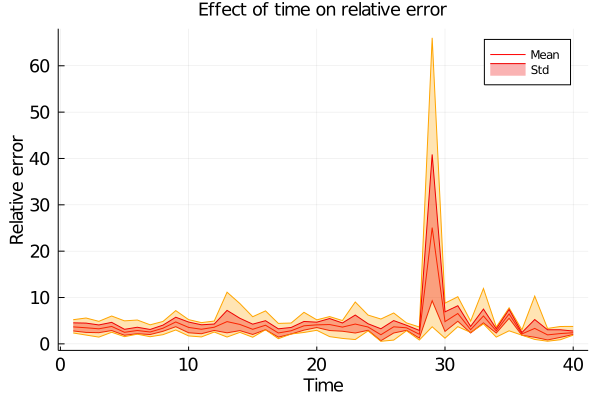

In [50]:
PLOTNAME = "AAA Effect of time "
plot()
plot!(Stat_SPEC_time[:,3], label = "Mean", c=:red1)
title!("Effect of time on relative error")
xaxis!("Time")
yaxis!("Relative error")
plot!(Stat_SPEC_time[:,1], label = false, c=:orange)
plot!(Stat_SPEC_time[:,5], c=:red2,label = false )
plot!(Stat_SPEC_time[:,2], fillrange=[Stat_SPEC_time[:,1], Stat_SPEC_time[:,2]], fillalpha=0.3, c=:orange, label=false)
plot!(Stat_SPEC_time[:,4], fillrange=[Stat_SPEC_time[:,5], Stat_SPEC_time[:,4]], fillalpha=0.3, c=:red2, label  = "Std")
#savefig(PATH_TO_OUTPUT*PLOTNAME)


## Measuring precision of estimation through relative error

In order to measure the effects of the noise on parameter estimation the relative error to the known value of parameters is measured.

The function **RelativeError** take as an input the reference value of the parameters and a matrix of dimension *NbParameters* x *NbExperiments* and return a matrix of identical dimension with relative error values instead of estimated value

*Tries on Dataframes:*

In [80]:
REL_ER = convert(DataFrame, REL_ER)
rename!(REL_ER, ["Vmaxtx","KTX","kdeg","Vmaxtl","KTL","kmat","lamb"])
println(REL_ER)

LoadError: UndefVarError: REL_ER not defined

In [163]:
PLOTNAME = "Relative error Vmaxtl only"
EST_PARA0 = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(t0POP)
    EST_PARA0[j, :] = i
    j += 1
end
REL_ER0 = RelativeError(PARAMS, EST_PARA0)
violin(xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]), REL_ER0, ylabel = "Relative error",label = false, title = "Parameter estimation with POPSIZE = 20 and 10 generations before ESS", )
#savefig(PATH_TO_OUTPUT*PLOTNAME)

LoadError: UndefVarError: t0POP not defined

In [237]:
INPOP

Dict{Any,Any} with 20 entries:
  18 => [3.31689e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  2  => [3.31277e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  16 => [3.31278e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  11 => [3.31319e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  7  => [3.31366e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  9  => [3.31337e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  10 => [3.31328e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  19 => [3.31213e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  17 => [3.31354e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  8  => [3.31221e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  6  => [3.31526e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  4  => [3.31039e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  3  => [3.31436e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  5  => [3.3161e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  20 => [3.3141e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  13 => [3.31518e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  14 => [3.3123e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]
  15 => [3.31333e7, 0.01, 0.01, 0.1, 0.1, 0.03, 0.02]


In [164]:
EST_PARA = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    EST_PARA[j, :] = i
    j += 1
end
REL_ER = RelativeError(PARAMS, EST_PARA)

20×7 Array{Float64,2}:
 6.64598   6.68749  3.60819   5.40446  0.99679    0.633247  5.25178
 0.104348  4.69565  4.83913   2.97391  8.42609    1.53913   0.469565
 6.82462   6.60077  3.58253   6.0654   0.997859   0.618638  6.65455
 6.16456   5.82473  2.08679   2.98293  0.935659   0.702368  2.35373
 6.04263   5.73088  2.99466   3.61097  0.999      0.621259  3.69907
 6.04304   5.73088  2.99355   3.61096  0.999      0.621256  3.69338
 5.86457   6.3625   3.66159   3.28865  0.999      0.634734  3.18084
 7.35575   6.48686  3.83195   7.17743  0.999      0.592675  8.10088
 5.9213    6.20873  2.38537   3.10727  0.789625   0.637429  2.71103
 2.34803   7.96023  6.42689   4.32913  1.58567    0.454365  0.968615
 5.92107   6.26281  2.37917   3.10346  0.757275   0.620991  2.56278
 7.13432   8.88108  1.05409   2.2754   0.0925024  0.490647  1.87188
 6.39581   6.41871  2.92747   3.74472  0.979368   0.636017  3.69588
 2.33635   7.96022  6.39571   4.18246  1.58584    0.443837  0.714084
 6.29524   5.90021  2.

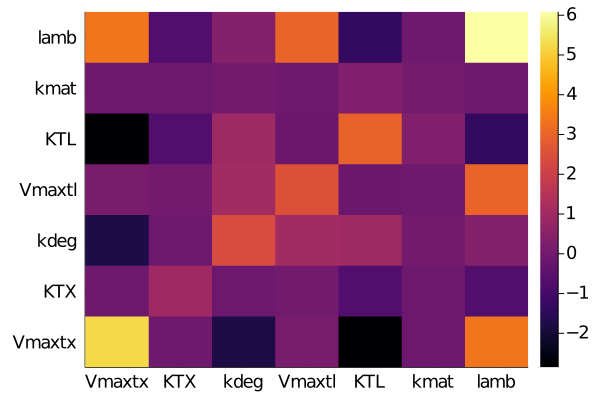

In [166]:
PLOTNAME = "Covariance matrix of all parameter n=10 s=20"
plot()
heatmap!(cov(REL_ER),xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]), yticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]))
#savefig(PATH_TO_OUTPUT*PLOTNAME)


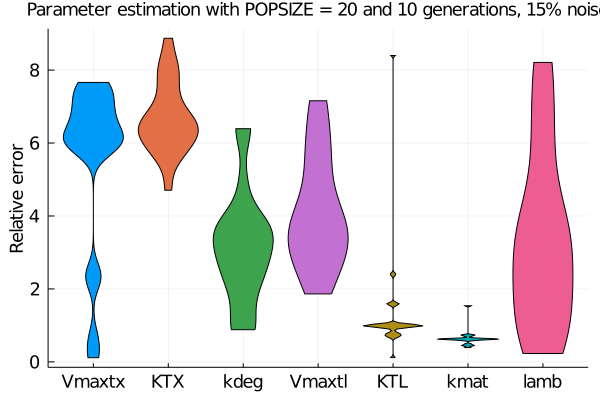

In [167]:

EST_PARA = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    EST_PARA[j, :] = i
    j += 1
end
REL_ER = RelativeError(PARAMS, EST_PARA)

PLOTNAME = "Relative error kdeg lamb"
violin( xticks=(1:7,["Vmaxtx" "KTX" "kdeg" "Vmaxtl" "KTL" "kmat" "lamb"]),label = false, REL_ER, ylabel = "Relative error", title = "Parameter estimation with POPSIZE = 20 and 10 generations, 15% noise" )
#savefig(PATH_TO_OUTPUT*PLOTNAME)


In [277]:
INPOP

Dict{Any,Any} with 20 entries:
  18 => [3210.94, 0.01, 0.01, 0.1, 0.0001, 0.03, 7.78076e-7]
  2  => [3230.16, 0.01, 0.01, 0.1, 0.0001, 0.03, 1.00851e-8]
  16 => [6390.92, 0.01, 0.01, 0.1, 0.0001, 0.03, 7.57539e-8]
  11 => [1331.76, 0.01, 0.01, 0.1, 0.0001, 0.03, 0.0001]
  7  => [2416.49, 0.01, 0.01, 0.1, 0.0001, 0.03, 2.7176e-7]
  9  => [1910.36, 0.01, 0.01, 0.1, 0.0001, 0.03, 3.86645e-7]
  10 => [2447.49, 0.01, 0.01, 0.1, 0.0001, 0.03, 6.66177e-9]
  19 => [6542.95, 0.01, 0.01, 0.1, 0.0001, 0.03, 6.50518e-8]
  17 => [1261.19, 0.01, 0.01, 0.1, 0.0001, 0.03, 1.39399e-5]
  8  => [2121.77, 0.01, 0.01, 0.1, 0.0001, 0.03, 0.0403146]
  6  => [2391.12, 0.01, 0.01, 0.1, 0.0001, 0.03, 8.28917e-7]
  4  => [5465.92, 0.01, 0.01, 0.1, 0.0001, 0.03, 2.486e-8]
  3  => [2540.93, 0.01, 0.01, 0.1, 0.0001, 0.03, 6.25628e-8]
  5  => [2303.71, 0.01, 0.01, 0.1, 0.0001, 0.03, 0.00114469]
  20 => [1801.44, 0.01, 0.01, 0.1, 0.0001, 0.03, 2.59667e-7]
  13 => [1993.42, 0.01, 0.01, 0.1, 0.0001, 0.03, 0.000408618]


## Following evolution of parameters estimation along the ESS

In [118]:
TOP1_REL = zeros(Float64, size(TOP1)[1], 7)


5×7 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [14]:
TOP1_REL = zeros(Float64, size(TOP1)[1], 7)
for i in 1:length(TOP1)
    TOP1_REL[i, :] = TOP1[i] - PARAMS
    TOP1_REL[i, :] = map(x -> abs(x), TOP1_REL[i, :])
    TOP1_REL[i, :] = TOP1_REL[i, :] ./ PARAMS
end
TOP1_REL

LoadError: UndefVarError: TOP1 not defined

In [30]:
for i in values(INPOP)
 println( Score(i,naive_ref))
end

11.389219988684081
3.763813545451952
17.22376721695874
5.739580253007058
1.565854907067028
2.853976386969494
6.775538239780352
11.168297895182935
7.8850656450761605
5.552205681471091
2.7364195536164657
1.4282332999692657
8.119769777267285
8.015809363925921
9.174307271475433
4.5448712064852606
2.2710815349446527
4.2568318058683765
6.005290894792549
7.5817902035664035


In [78]:
INPOP

Dict{Any,Any} with 20 entries:
  18 => [0.621943, 0.513135, 0.0679271, 0.198424, 3.77852e-5, 0.0900458, 0.0961…
  2  => [0.966882, 0.00440663, 0.0819504, 0.152588, 0.102915, 0.0227492, 0.0294…
  16 => [0.667444, 0.0364375, 0.0457105, 0.202206, 0.0001, 0.0417348, 0.0752036]
  11 => [0.683861, 0.0001, 0.0434335, 0.184037, 0.0001, 0.0310722, 0.0544975]
  7  => [0.997089, 0.00460761, 0.0563685, 0.109612, 0.0904118, 0.0232288, 0.020…
  9  => [0.983564, 0.00436708, 0.0778661, 0.145055, 0.104963, 0.0220014, 0.0264…
  10 => [0.972414, 0.0141058, 0.0636256, 0.071699, 0.0855882, 0.149692, 0.01451…
  19 => [0.991965, 1.44129, 0.0264832, 0.22825, 0.0001, 4.84878, 0.145231]
  17 => [0.660046, 0.325463, 0.0459071, 0.20652, 0.0001, 0.0638796, 0.0930661]
  8  => [0.899946, 0.419175, 0.0984191, 0.096934, 0.0228757, 0.707242, 0.006552…
  6  => [0.986746, 0.0001, 0.065923, 0.167565, 0.116792, 0.0238409, 0.0442934]
  4  => [0.586279, 0.358911, 0.0309348, 0.0566594, 0.032072, 0.668683, 0.0001]
  3  => [1.0

In [30]:
t0POP

Dict{Any,Any} with 20 entries:
  18 => [0.91662, 9.57047e-5, 0.0178582, 0.190128, 0.0620729, 0.059314, 0.07559…
  2  => [1.14193, 0.000168938, 0.00636454, 0.164955, 0.289974, 0.0285783, 0.041…
  16 => [0.873931, 9.9301e-5, 0.0190692, 0.188669, 0.0710713, 0.284442, 0.22280…
  11 => [1.18433, 0.0001, 0.00835631, 0.141751, 0.324645, 0.0209734, 0.0317252]
  7  => [1.10433, 0.0175313, 0.0107059, 0.178625, 0.0001, 0.0284718, 0.0517952]
  9  => [1.10725, 0.0175636, 0.00999759, 0.178134, 0.0001, 0.0268391, 0.0520687]
  10 => [0.898408, 9.56554e-5, 0.0188164, 0.189915, 0.0587621, 0.0628688, 0.079…
  19 => [1.06896, 0.0190326, 0.013583, 0.178263, 0.0001, 0.0323785, 0.0575366]
  17 => [0.872086, 0.000100007, 0.0195591, 0.189085, 0.0684658, 0.128644, 0.096…
  8  => [1.15935, 0.0001, 0.00771987, 0.167622, 0.299212, 0.0216262, 0.0368908]
  6  => [1.1676, 0.0157653, 0.0110092, 0.0873642, 0.200789, 0.0298245, 0.013944…
  4  => [1.10307, 0.0175241, 0.0114021, 0.171771, 0.0001, 0.0268235, 0.0481151]
  3

In [32]:
PARA_VAL = zeros(Float64, POPSIZE, 7)
PARA_VAL[1, :]

7-element Array{Float64,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [38]:
PLOTNAME = "Log of Parameters variation before ESS high initial variation with noise 5"
j = 1
for i in values(t0POP)
    PARA_VAL[j, :] = i
    j += 1
end
println(PARA_VAL)
PARA_VAL = map(x -> log(x), PARA_VAL)

violin( PARA_VAL, leg = false)
savefig(PATH_TO_OUTPUT*PLOTNAME)


[0.9021739130434783 0.10956521739130436 0.06717391304347826 0.1889855072463768 0.034782608695652174 0.32956521739130434 0.2514492753623188; 0.8586956521739131 0.03326086956521739 0.12086956521739131 0.10086956521739131 0.018260869565217393 0.4289855072463768 0.03840579710144928; 1.3369565217391304 0.021956521739130434 0.07565217391304348 0.1036231884057971 0.07057971014492753 0.30826086956521737 0.2727536231884058; 1.184782608695652 0.030434782608695653 0.016304347826086956 0.04579710144927537 0.05130434782608696 0.28695652173913044 0.10231884057971014; 1.358695652173913 0.14347826086956522 0.021956521739130434 0.08434782608695651 0.012753623188405797 0.03840579710144928 0.10942028985507245; 1.1304347826086958 0.04456521739130435 0.06434782608695652 0.15869565217391304 0.08710144927536231 0.4076811594202898 0.1236231884057971; 1.5 0.0191304347826087 0.07847826086956522 0.06231884057971015 0.12014492753623188 0.21594202898550724 0.0881159420289855; 1.391304347826087 0.135 0.081304347826

In [94]:
mean!([1. 1. 1. 1. 1. 1. 1.], PARA_VAL)

1×7 Array{Float64,2}:
 0.0911606  -2.68095  -2.63402  -2.34906  -2.65049  -1.5974  -1.77592

In [40]:
PLOTNAME = "Log of Parameters variation after ESS high initial variation with noise 5"
j = 1
for i in values(t0POP)
    PARA_VAL[j, :] = i
    j += 1
end
Para_after_ESS = copy(PARA_VAL)
PARA_VAL = map(x -> log(x), PARA_VAL)
violin( PARA_VAL, leg = false)
savefig(PATH_TO_OUTPUT*PLOTNAME)


In [96]:
logMEAN = mean!([1. 1. 1. 1. 1. 1. 1.], PARA_VAL)
MEAN = map(x -> exp(x), logMEAN)
println(MEAN)

[0.40150110867380995 0.00035653991741131067 0.1243174608551118 0.19760075027208487 0.0003499222116455093 0.12671585789231996 0.05042488017515262]


In [88]:
PARAMS[1.0839, 0.0191987, 0.0132601, 0.178977, 0.0001, 0.0299982, 0.0554689]

7-element Array{Float64,1}:
 1.0
 0.01
 0.01
 0.1
 0.1
 0.03
 0.02

## FIM computation

In [292]:
PARA_VAL = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    PARA_VAL[j, :] = i
    j += 1
end
Para_after_ESS = copy(PARA_VAL)

20×7 Array{Float64,2}:
 1.0  0.01  0.01  0.1  0.1  0.03  2.72015e-6
 1.0  0.01  0.01  0.1  0.1  0.03  6.61287e-6
 1.0  0.01  0.01  0.1  0.1  0.03  1.46028e-7
 1.0  0.01  0.01  0.1  0.1  0.03  0.000563435
 1.0  0.01  0.01  0.1  0.1  0.03  9.93016e-7
 1.0  0.01  0.01  0.1  0.1  0.03  5.5685e-6
 1.0  0.01  0.01  0.1  0.1  0.03  1.16936e-6
 1.0  0.01  0.01  0.1  0.1  0.03  4.41246e-6
 1.0  0.01  0.01  0.1  0.1  0.03  3.34984e-6
 1.0  0.01  0.01  0.1  0.1  0.03  4.52e-6
 1.0  0.01  0.01  0.1  0.1  0.03  7.03418e-6
 1.0  0.01  0.01  0.1  0.1  0.03  5.78399e-6
 1.0  0.01  0.01  0.1  0.1  0.03  1.44849e-6
 1.0  0.01  0.01  0.1  0.1  0.03  4.55181e-6
 1.0  0.01  0.01  0.1  0.1  0.03  4.7314e-6
 1.0  0.01  0.01  0.1  0.1  0.03  0.00018804
 1.0  0.01  0.01  0.1  0.1  0.03  7.70939e-5
 1.0  0.01  0.01  0.1  0.1  0.03  2.03879e-5
 1.0  0.01  0.01  0.1  0.1  0.03  0.000421129
 1.0  0.01  0.01  0.1  0.1  0.03  1.07126e-6

In [44]:
COVMATRIX =  cov(Para_after_ESS)

7×7 Array{Float64,2}:
  0.113551     0.0196507    -0.0152885   …  -0.539545   -0.0195871
  0.0196507    0.00460815   -0.00233796     -0.0888028  -0.00295298
 -0.0152885   -0.00233796    0.00228997      0.0708905   0.00280718
 -0.0097014   -0.00147199    0.00149403      0.0375631   0.00190214
  0.00538494  -0.000434772  -0.00123735     -0.0199093  -0.00144137
 -0.539545    -0.0888028     0.0708905   …   3.90964     0.0920151
 -0.0195871   -0.00295298    0.00280718      0.0920151   0.00517823

In [45]:
DCRIT = det(COVMATRIX)

3.151909430727244e-18

### Intervale dilution

In [17]:
DILUTION = [5, 10, 25, 50, 100]
DILFRAC  = [0.1, 0.3, 0.5, 0.7, 0.9]
SWITCHTIMES = 0.1
INTERVAL_DIL = 15.00
SCORE_mat_D = zeros(Float64, size(DILUTION)[1], size(DILFRAC)[1])
SCORE_mat_E = copy(SCORE_mat_D)
SCORE_maxt = []
dil = 0
tim = 0
online = 1
IniPara = [(1,1)]
for DIL in DILFRAC
    dil += 1
    tim = 0
    for TIM in DILUTION
        tim += 1
        println(DIL)
        DIL_FRAC = DIL
        INTERVAL_DIL = TIM
        naive_ref = SimPmat(model!,u0, PARAMS,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES)
        #Add noise to the simulated experiment
        naive_ref = add_gauss(naive_ref, 0.1)
        naive_ref = Positive(naive_ref)
        INPOP =  ESS_seq(POPSIZE, NBGEN, PARA_ref, PARA_var, naive_ref,TMAX,INTERVAL_DIL,TSAVE,DIL_FRAC,NSPECIES,SWITCHTIMES,online,IniPara)
#Savegarde
PARA_VAL = zeros(Float64, POPSIZE, 7)
j = 1
for i in values(INPOP)
    PARA_VAL[j, :] = i
    j += 1
end
COVMATRIX = cov(PARA_VAL)
COVMATRIX = inv(COVMATRIX)
EIGENVAL = eigvals(COVMATRIX)
MIN = EIGENVAL[1]
MAX = EIGENVAL[length(EIGENVAL)]
ECRIT = MIN/MAX
DCRIT = det(COVMATRIX )
SCORE_mat_E[tim, dil] = ECRIT
SCORE_mat_D[tim, dil] = DCRIT
end
end

.4502731575991186
Generation 16
Best score:1.350883073054783 Worst score:1.4502731575991186
Generation 17
Best score:1.3505901230545527 Worst score:1.3771189566897546
0.5
[(0.1, 10.0), (0.001, 0.1), (0.001, 0.1), (0.01, 1.0), (0.01, 1.0), (0.003, 0.3), (0.002, 0.2)]
Generation 1
Best score:5.035577148255033 Worst score:19.628854119238415
Generation 2
Best score:1.6785091159425074 Worst score:19.248124809322206
Generation 3
Best score:1.3881909625831412 Worst score:18.42666803655011
Generation 4
Best score:1.3881909625831412 Worst score:13.42882753688124
Generation 5
Best score:1.3881909625831412 Worst score:6.5704866344115365
Generation 6
Best score:1.3483254577344626 Worst score:4.481924840107514
Generation 7
Best score:1.3483254577344626 Worst score:3.454741194382653
Generation 8
Best score:1.3382406745554312 Worst score:2.919125257203807
Generation 9
Best score:1.3382406745554312 Worst score:2.919125257203807
Generation 10
Best score:1.3382406745554312 Worst score:2.919125257203807


In [18]:
SCORE_mat_Db = copy(SCORE_mat_D)
SCORE_mat_Db =map(x -> log(x),SCORE_mat_Db)

5×5 Array{Float64,2}:
 40.4546  33.5008  30.6458  26.8363  11.4185
 42.6783  34.7949  34.8135  31.7162  29.5775
 62.137   70.3036  39.7059  42.4032  35.0286
 77.3079  54.2731  40.9189  35.0119  51.7432
 59.4422  60.9811  64.1777  52.2684  56.6893

In [29]:
SCORE_mat_Db[1,2]

-39.67647046949021

In [53]:
xlabel = string.(collect('A':'E'))

5-element Array{String,1}:
 "A"
 "B"
 "C"
 "D"
 "E"

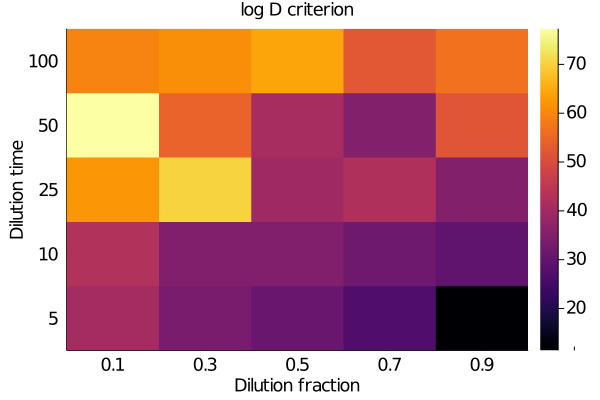

In [19]:
PLOTNAME = "AAA heatmap D crit no noise.svg"
heatmap(SCORE_mat_Db, title= "log D criterion", ylabel = "Dilution time", xlabel = "Dilution fraction", yticks= (1:7, ("5", "10", "25", "50", "100")),  xticks= (1:9, ("0.1","0.3", "0.5", "0.7", "0.9")))
#savefig(PATH_TO_OUTPUT*PLOTNAME)

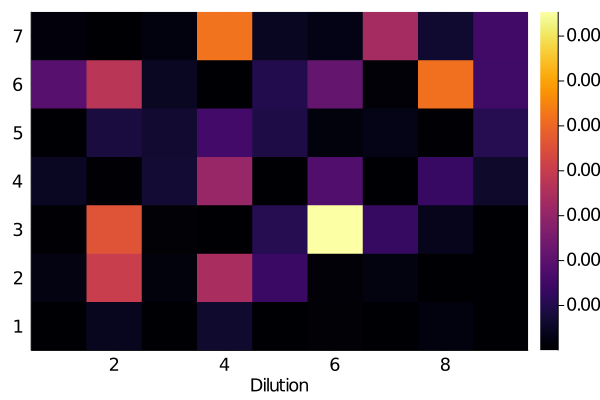

In [72]:
heatmap(SCORE_mat_E, xlabel="Dilution")

In [20]:
SCORE_mat_Eb = copy(SCORE_mat_E)
SCORE_mat_Eb = Positive(SCORE_mat_Eb)
SCORE_mat_Eb =map(x -> log(x),SCORE_mat_Eb)

5×5 Array{Float64,2}:
 -19.889   -11.0261  -10.1302  -10.3148   -15.5642
 -16.048   -10.1301  -10.6001   -9.01842  -10.7155
 -17.6117  -19.1155  -13.3578  -16.6806   -12.5746
 -16.6609  -20.1491  -12.5726  -16.4148   -21.9435
 -16.802   -23.4187  -18.674   -16.3815   -19.6302

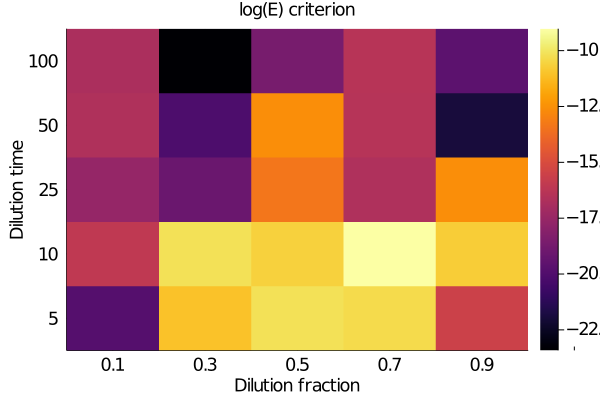

In [21]:
PLOTNAME = "AAA heatmap E crit no noise.svg"
heatmap(SCORE_mat_Eb, title= "log(E) criterion", ylabel = "Dilution time", xlabel = "Dilution fraction", yticks= (1:7, ("5", "10", "25", "50", "100")),  xticks= (1:9, ("0.1","0.3", "0.5", "0.7", "0.9")))
#savefig(PATH_TO_OUTPUT*PLOTNAME)

In [63]:
SCOREDILL

9-element Array{Any,1}:
 1.6497861735257515e-19
 2.990773632699954e-19
 1.4461847096034843e-20
 8.635737669484489e-22
 9.755297538297536e-21
 6.96294798920682e-24
 2.4026398654124373e-20
 8.716926796276201e-29
 9.87000146806749e-23

In [64]:
PLOTNAME = "D criterion on dillution fraction"
p = plot(grid=:false,legend=:true,framestyle=:frame,size=(600,400))
SCOREDILL = map(x -> log(x), SCOREDILL)
plot!(DILFRAC, SCOREDILL, lw=2, labels="Pmat") 
savefig(PATH_TO_OUTPUT*PLOTNAME)

In [57]:
PARA_VAL

20×7 Array{Float64,2}:
 2.34092  0.0001    0.355138  1.98251   0.0001     0.11165    1.29294
 2.29495  0.0001    0.396001  1.80847   0.0001     0.0387281  0.783675
 2.33769  0.0001    0.352017  1.98345   0.0001     0.0826912  1.13095
 2.27946  0.0001    0.409883  1.82412   0.0001     0.0300077  0.709283
 0.97396  0.939113  1.23604   1.24206   0.0001     0.0124497  0.258078
 2.51284  0.0001    0.0001    0.520699  0.0001    12.7192     0.29384
 2.26085  0.0001    0.422971  1.92596   0.0001     6.52606    3.08567
 2.27861  0.0001    0.413657  1.83177   0.0001     0.0327308  0.773703
 2.34236  0.0001    0.357068  1.9832    0.0001     0.107953   1.29164
 2.29463  0.0001    0.396979  1.82368   0.0001     0.0394221  0.797251
 2.54669  0.0001    0.0001    0.616511  0.0001    11.1062     0.36922
 2.43126  0.931555  0.332856  1.6009    0.447402   5.58253    0.0001
 2.28372  0.0001    0.403922  1.80874   0.0001     0.0300407  0.694516
 2.3264   0.0001    0.375301  1.93962   0.0001     0.081988   

In [50]:
PARA_VAL = map(x -> exp(x), PARA_VAL)
CORRPARA = PARA_VAL[:, 1:5]

20×5 Array{Float64,2}:
 1.18186  1.0001   1.25254  1.21459  1.0001
 2.66833  1.15133  1.1157   1.11124  1.00038
 1.07657  1.0001   1.25949  1.21167  1.0001
 2.23447  1.17029  1.15669  1.19681  1.0001
 2.46681  1.15169  1.14244  1.16141  1.00007
 2.41612  1.15172  1.16752  1.1779   1.0001
 2.53151  1.15173  1.14892  1.14134  1.00001
 1.55144  1.0001   1.21364  1.22541  1.0001
 1.37651  1.0001   1.23115  1.21911  1.0001
 2.70387  1.06886  1.10842  1.13816  1.13846
 2.47145  1.15151  1.14169  1.1616   1.00004
 2.6932   1.1507   1.10255  1.09107  1.00788
 2.41357  1.05862  1.10939  1.13501  1.15046
 2.23562  1.15828  1.15669  1.19342  1.0001
 1.31537  1.0001   1.25977  1.21929  1.0001
 1.34918  1.0001   1.23296  1.21478  1.0001
 2.58207  1.16294  1.15488  1.14143  1.0001
 1.12526  1.0001   1.25675  1.21463  1.0001
 2.41482  1.15238  1.16714  1.17787  1.0001
 2.41557  1.05839  1.10939  1.13501  1.15103

In [52]:
PLOTNAME = "Correlation on 5 first parameters bigVar"
corrplot(CORRPARA, label = ["Vmaxtx","KTX","kdeg","Vmaxtl","KTL"], size =(1800, 1500))
savefig(PATH_TO_OUTPUT*PLOTNAME)


## 3. Calibrate model to titration data

In [11]:
# Get data (more info about experiment in data folder)

PATH_TO_DATA = "./data/"
xf = XLSX.readxlsx(PATH_TO_DATA*"data_capacity_in_nM.xlsx")
sheetname = XLSX.sheetnames(xf)[1]

sh = xf[sheetname]
data = sh[:]

t = data[2:end,1]*60 # convert time to minutes
y = data[2:end,2:10]
dy = data[2:end,12:20]

conds = [
60.3,
44.5,
22.25,
11.125,
5.5625,
2.78125,
1.390625,
0.6953125,
0.34765625]

# Each trajectory can be taken as follows:
ydata=y[:,1];

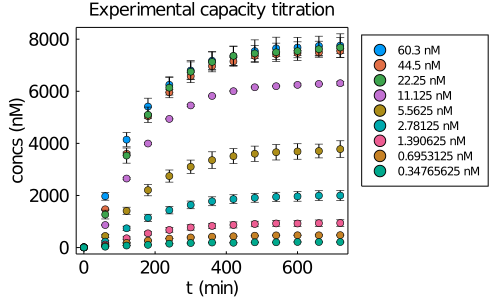

In [12]:
# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
p = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

# Plot every trajectory
for idx in 1:size(conds)[1]
    scatter!(t,y[:,idx], yerror=dy[:,idx], lw=2, 
        labels=string(conds[idx])*" nM",legend = :outertopright) 
end

plot!(xaxis = "t (min)",yaxis="concs (nM)", title="Experimental capacity titration")

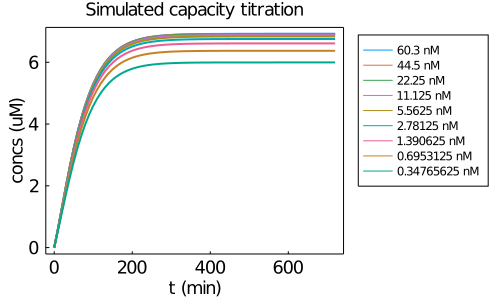

In [13]:
# Set up model to simulate titration (in batch, no microfluidics)

d0=0.001;
m0=0.0;
P0=2.0;
Pmat0=0.0;
A0=1.0;

Vmaxtx=1.0;
KTX=0.01;
kdeg=0.01;
Vmaxtl=0.1;
KTL=0.1;
kmat=0.03;
lamb=0.02;

u0 = [d0,m0,P0,Pmat0,A0];
PARAMS = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb];

tspan = 0,Float64(12*60) # time in min
prob = ODEProblem(model!,u0,tspan,PARAMS);

# Solve ODEs
prob = ODEProblem(model!,u0,tspan,PARAMS)

# Plot options

fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

for idx in 1:size(conds)[1]
    
    modprob = remake(prob, p=params, u0=[conds[idx]/1000,m0,P0,Pmat0,A0])
    sol = solve(modprob,saveat=10);
    tsim = sol.t
    Pmat = [datum for subarr in sol.u for datum in subarr[idx_Pmat]];
    plot!(tsim,Pmat, lw=2, 
        labels=string(conds[idx])*" nM",legend = :outertopright) 
end

plot!(xaxis = "t (min)",yaxis="concs (uM)", title="Simulated capacity titration")

The aim is to vary model parameters such that simulated data agrees with experimental data. I will demonstrate for just one trajectory; in the end the entire data set should be used.

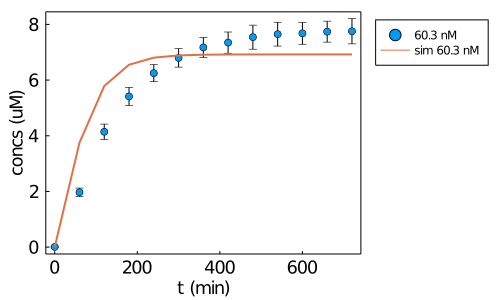

In [14]:
# Experimental data for 60.3 nM
ydata=y[:,1]/1000; # in uM
ystdev=dy[:,1]/1000; # in uM

# Model output for 60.3 nM
dsel = 60.3/1000 # DNA concentration in uM
modprob = remake(prob, p=PARAMS, u0=[dsel,m0,P0,Pmat0,A0])
sol = solve(modprob,saveat=60);
tsim = sol.t
Pmat = [datum for subarr in sol.u for datum in subarr[idx_Pmat]];

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

scatter!(t,ydata, yerror=ystdev, lw=2, 
    labels="60.3 nM",legend = :outertopright)
plot!(tsim,Pmat, lw=2, 
        labels="sim 60.3 nM",legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)")

In [15]:
# Define simple L2 cost function
PARAMS = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb]
u0=[dsel,m0,P0,Pmat0,A0]
prob = ODEProblem(model!,u0,tspan,PARAMS)

cost_function = build_loss_objective(prob, Tsit5(),
                L2Loss(tsim,ydata),
    maxiters=10000000,verbose=true,save_idxs=4) # save only observable protein output

# Check to see if cost function evaluates
cost_function(PARAMS)

10.592180770907586

Best fit params: [1.5048670178577808, 0.00910313299098545, -0.0064440154659771605, 0.10361598037132659, 0.11895462669778561, 0.00965146807639961, 0.018055425021167394]

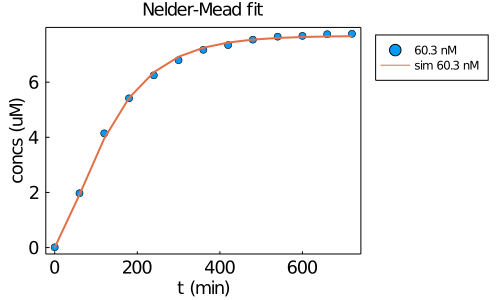

In [16]:
# Local optimization example (Nelder-Mead)

result = optimize(cost_function,PARAMS,iterations=100)
PARAMSfit=Optim.minimizer(result)

mod_prob = remake(prob, p=PARAMSfit)
mod_sol = solve(mod_prob, Tsit5(), saveat=60, verbose=true,maxiters=1000000,save_idxs=4)
ymodelfit = Array(mod_sol)

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

scatter!(t,ydata, lw=2, 
    labels="60.3 nM",legend = :outertopright)
plot!(tsim,ymodelfit, lw=2, 
        labels="sim 60.3 nM",legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)", title="Nelder-Mead fit")

print("Best fit params: ", paramsfit)
pl


The fit appears good but notice some of the parameters are negative, which may be unphysical. The possible parameter ranges can be constrained to be positive, or (a better solution) you can fit the log-parameter values instead.

SAMIN results
==> WARNING <==
Last point satisfies convergence criteria, but is near
boundary of parameter space.
13 out of  175 evaluations were out of bounds in the last round.
Expand bounds and re-run, unless this is a constrained minimization.
total number of objective function evaluations: 72626

     Obj. value:      0.0141436051

       parameter      search width
         0.46344           0.00000 
         0.10000           0.00000 
         0.01300           0.00000 
         0.47307           0.00000 
         1.00000           0.00000 
         0.00746           0.00000 
         0.04518           0.00000 

Best fit params: [0.4634388394170698, 0.09999999999999104, 0.012997714589608422, 0.4730737924328584, 0.9999999999999941, 0.007458555907771868, 0.04518024370321594]

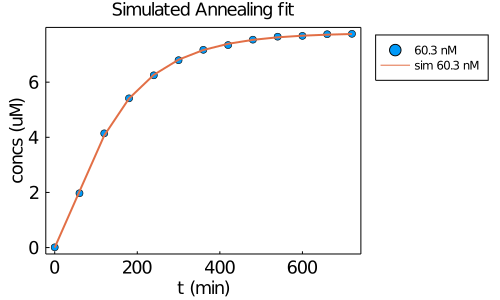

In [17]:
# Global optimization example (Simulated Annealing with bounds)

lowerbounds = PARAMS*0.0
upperbounds = PARAMS*10.0
result = optimize(cost_function,lowerbounds,upperbounds,PARAMS, SAMIN(), 
    Optim.Options(iterations=100000,time_limit=100)) 
paramsfit=Optim.minimizer(result)

mod_prob = remake(prob, p=paramsfit)
mod_sol = solve(mod_prob, Tsit5(), saveat=60, verbose=true,maxiters=1000000,save_idxs=4)
ymodelfit = Array(mod_sol)

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:true,framestyle=:frame,size=(500,300))

scatter!(t,ydata, lw=2, 
    labels="60.3 nM",legend = :outertopright)
plot!(tsim,ymodelfit, lw=2, 
        labels="sim 60.3 nM",legend = :outertopright) 
plot!(xaxis = "t (min)",yaxis="concs (uM)", title="Simulated Annealing fit")

print("Best fit params: ", paramsfit)
pl


Global optimizers are preferred because we know our system has many local minima. However they are very expensive computationally and also require fine-tuning.

In [18]:
# Bayesian example

Turing.setadbackend(:forwarddiff) # Details here: forwarddiff ok for small models, for 
                                  # larger models require adjoint 

# Define our probabilistic model
@model function fitlv(data)
    σ ~ InverseGamma(2, 3) 
    Vmaxtx ~ truncated(Normal(1.0,0.5),0,10) # mean, sigma, lower bound, upper bound
    KTX ~ truncated(Normal(0.01,0.005),0,0.1)
    kdeg ~ truncated(Normal(0.01,0.005),0,0.1)
    Vmaxtl ~ truncated(Normal(0.1,0.05),0,1)
    KTL ~ truncated(Normal(0.1,0.05),0,1)
    kmat ~ truncated(Normal(0.03,0.015),0,0.3)
    lamb ~ truncated(Normal(0.02,0.01),0,0.2)
    
    PARAMS = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb] # Draw parameters from prior distribution
    prob = ODEProblem(model!,u0,tspan,PARAMS)
    predicted = solve(prob,Tsit5(),saveat=60,save_idxs=4) 

    for i = 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ) # generate synthetic data with σ-normal distribution noise
    end
end

modelbayes = fitlv(ydata) # Fit model to synthetic data generated earlier
chain = sample(modelbayes, NUTS(.65),1000) # No U turn sampler

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/nadanai/.julia/packages/Turing/O1Pn0/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:17


Chains MCMC chain (1000×20×1 Array{Float64,3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = KTL, KTX, Vmaxtl, Vmaxtx, kdeg, kmat, lamb, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

         KTL    0.1019    0.0488     0.0015    0.0051    86.7736    1.0011
         KTX    0.0105    0.0049     0.0002    0.0002   411.7258    0.9993
      Vmaxtl    0.1099    0.0437     0.0014    0.0037   106.0293    1.0366
      Vmaxtx    1.0152    0.4659     0.0147    0.0303   370.2877    1.0052
        kdeg    0.0100    0.0046     0.0001    0.0003   325.2236    0.9990
        kmat    0.0111    0.0039     

For Bayesian inference we must propose an initial distribution ('prior') for our parameters. Here we have taken normal distributions around the initial parameter values, truncated within bounds as for the global optimizer. There are more sophisticated ways to set up priors. 

The result is a posterior distribution over the parameters, whose samples are given in a chain object. We can interrogate this object to view the distributions.

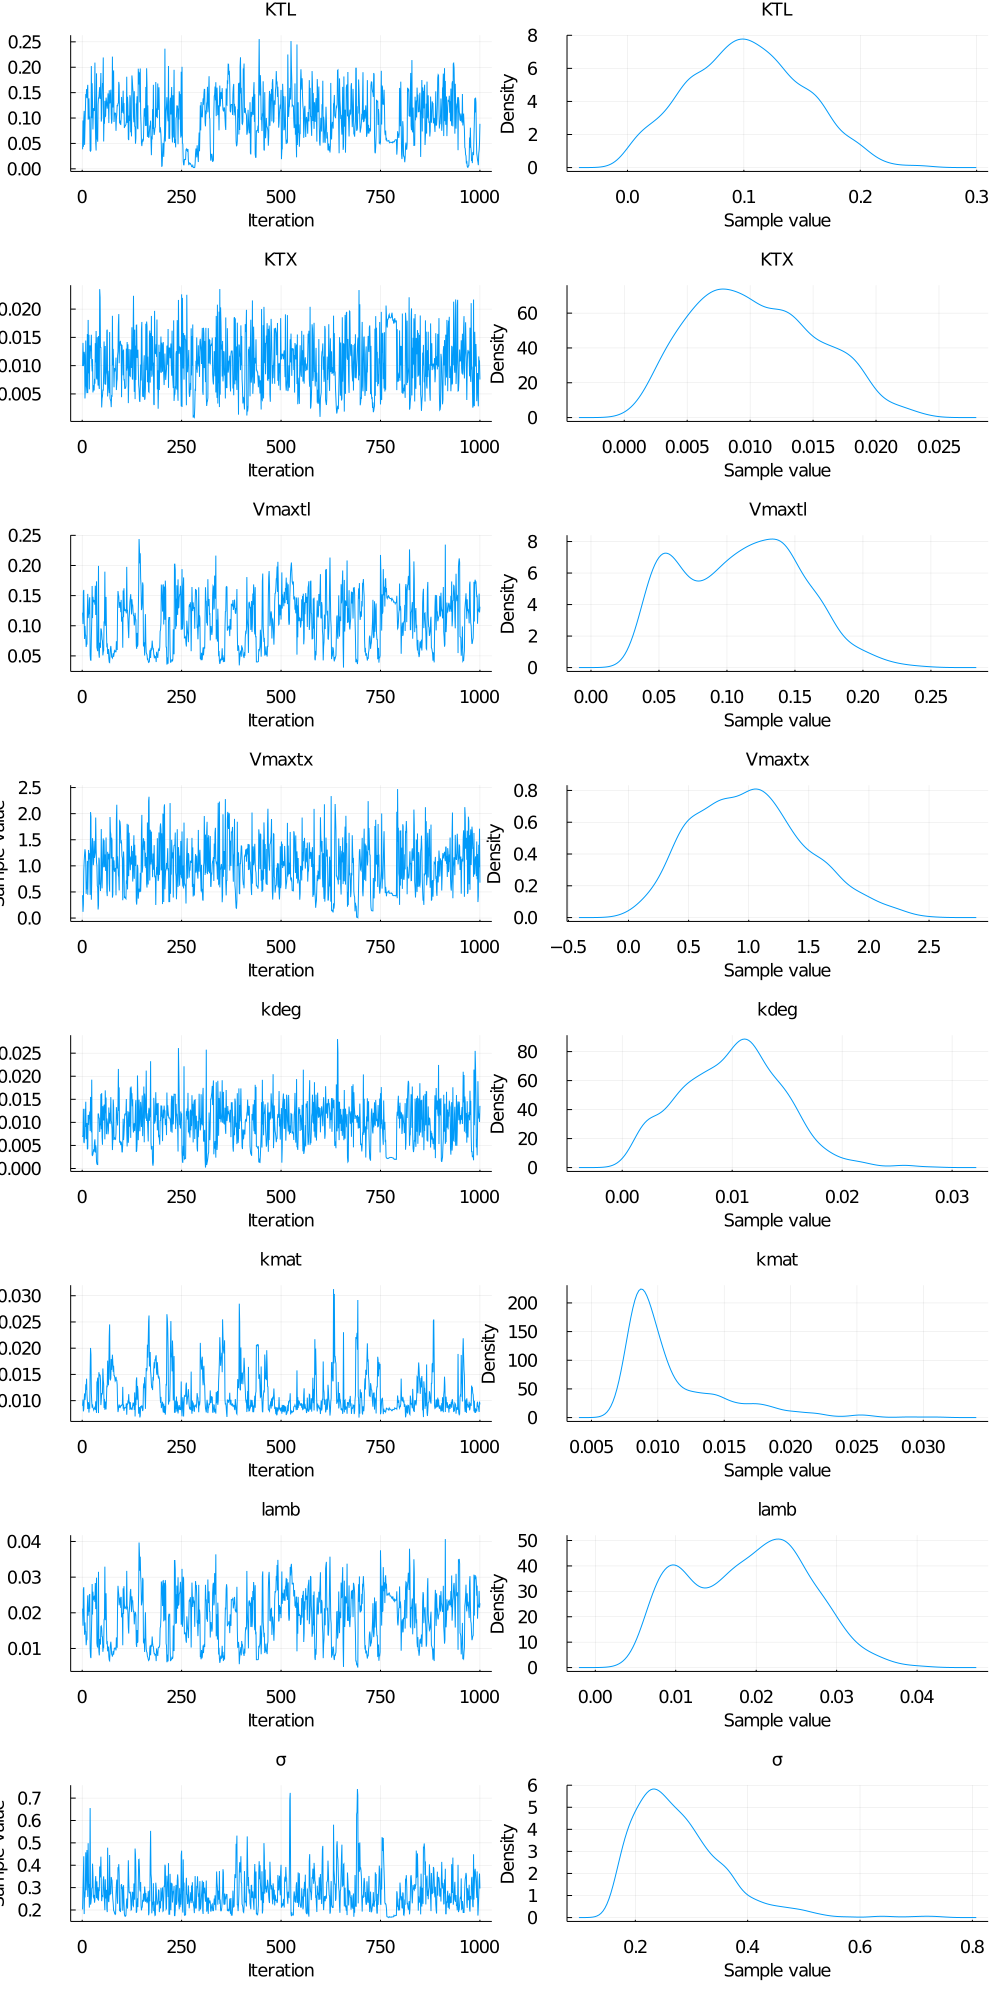

In [19]:
# The chain object contains the samples from the posterior distribution
# For example the samples for parameter KTX can be accessed:
# a = Array(chain[:KTX]);

# The StatsPlots package handles chains automatically. 
# You can get density plots
# plot(chain[:KTX],seriestype=:density)

# Or even a summary of the entire chain object
plot(chain)

In [20]:
# Let's convert the chain to a dataframe and use this to 
# obtain samples, to plot an ensemble model result
dfc=DataFrame(chain);
print(names(dfc))
samples = [dfc[!,:Vmaxtx] dfc[!,:KTX]  dfc[!,:kdeg] dfc[!,:Vmaxtl] dfc[!,:KTL] dfc[!,:kmat] dfc[!,:lamb]];

["iteration", "chain", "KTL", "KTX", "Vmaxtl", "Vmaxtx", "acceptance_rate", "hamiltonian_energy", "hamiltonian_energy_error", "is_accept", "kdeg", "kmat", "lamb", "log_density", "lp", "max_hamiltonian_energy_error", "n_steps", "nom_step_size", "numerical_error", "step_size", "tree_depth", "σ"]

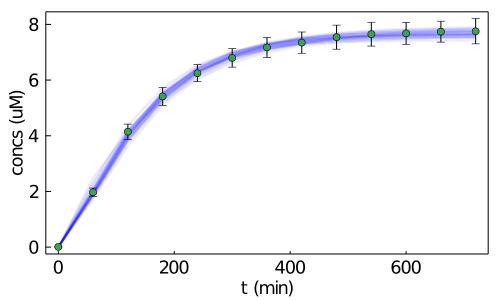

In [21]:
# Experimental data for 60.3 nM
ydata=y[:,1]/1000; # in uM
ystdev=dy[:,1]/1000; # in uM

# Model output for 60.3 nM
dsel = 60.3/1000 # DNA concentration in uM
u0=[dsel,m0,P0,Pmat0,A0]
PARAMS = [Vmaxtx,KTX,kdeg,Vmaxtl,KTL,kmat,lamb];
prob = ODEProblem(model!,u0,tspan,PARAMS)

# Plot comparison
fntsm = Plots.font("sans-serif", pointsize=round(8.0))
fntlg = Plots.font("sans-serif", pointsize=round(12.0))
default(titlefont=fntlg, guidefont=fntlg, tickfont=fntlg, legendfont=fntsm)
pl = plot(grid=:false,legend=:false,framestyle=:frame,size=(500,300))

# Run simulation 50 times with random parameter values drawn from posterior distribution
for j in 1:50
    modprob = remake(prob, p=samples[rand(1:1000),:], u0=[dsel,m0,P0,Pmat0,A0])
    sol = solve(modprob,saveat=60);
    tsim = sol.t 
    Pmat = [datum for subarr in sol.u for datum in subarr[idx_Pmat]];
    plot!(tsim,Pmat, lw=2, alpha=0.05, color="blue") 
end

scatter!(t,ydata, yerror=ystdev, lw=2)

plot!(xaxis = "t (min)",yaxis="concs (uM)")

Such an ensemble plot is generated by running the simulation multiple times using parameter values drawn from the posterior distribution, and allows us to visualise the parameter uncertainty directly in comparison to our experimental data. It is the preferred way to represent models whose parameters are inferred using Bayesian techniques.

Notice that here we have not yet done a proper treatment of experimental uncertainty. 